In [1]:
# Cell 1: Section 1 - Initialization: Imports
#
# Import all required libraries for the project.
#

# --- Core Libraries ---
import os
import sys
import logging
import time

# --- Data Handling ---
import pandas as pd
import numpy as np

import findspark
findspark.init()
# --- PySpark Core ---
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnan, avg, stddev, min, max, sum, lit, broadcast
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType
from pyspark.sql.window import Window

# --- PySpark ML (Preprocessing) ---
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation

# --- PySpark ML (Models) ---
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
# from pyspark.ml.clustering import IsolationForest # Note: Requires Spark 3.0+ 
from sklearn.ensemble import IsolationForest
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Model Evaluation (Local) ---
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

print("="*80)
print("Cell 1: All libraries imported successfully.")
print(f"PySpark Version: {pyspark.__version__}")
print("="*80)

Cell 1: All libraries imported successfully.
PySpark Version: 2.4.8


In [2]:
# Cell 2: Section 1 - Logging and Path Configuration
#
# Configure logging, define all project paths, and create output directories.
#

# --- 1. Configure Logging ---
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
log = logging.getLogger("FraudDetectionLogger")
log.info("Logging initialized.")

# --- 2. Define Project Paths ---
try:
    # Get the user's home directory 
    HOME_DIR = '/home/smitvd22' 
    
    # Base project directory
    PROJECT_DIR = os.path.join(HOME_DIR, 'SparkProject')
    
    # --- Local Paths (for initial ingest) ---
    LOCAL_DATASET_PATH = os.path.join(PROJECT_DIR, 'dataset', 'PS_20174392719_1491204439457_log.csv')
    
    # --- HDFS Paths (for all processing) ---
    HDFS_BASE_PATH = f"/user/smitvd22/fraud_detection"
    HDFS_DATA_PATH = f"{HDFS_BASE_PATH}/data/transactions.parquet"
    
    # --- *** NEW: HDFS Paths for intermediate DataFrames *** ---
    HDFS_INTERMEDIATE_PATH = f"{HDFS_BASE_PATH}/intermediate"
    HDFS_PROCESSED_PATH = f"{HDFS_INTERMEDIATE_PATH}/processed.parquet"
    HDFS_UNBALANCED_TRAIN_PATH = f"{HDFS_INTERMEDIATE_PATH}/unbalanced_train.parquet"
    HDFS_TEST_PATH = f"{HDFS_INTERMEDIATE_PATH}/test.parquet"
    HDFS_TRAIN_PATH = f"{HDFS_INTERMEDIATE_PATH}/train_balanced.parquet"
    # --- *** ---
    
    # --- Hive Configuration ---
    HIVE_DB_NAME = "fraud_detection_db"
    HIVE_TABLE_NAME = "transactions"
    
    # --- Output & Model Paths ---
    OUTPUT_DIR = os.path.join(PROJECT_DIR, 'output')
    PLOT_OUTPUT_DIR = os.path.join(OUTPUT_DIR, 'plots')
    METRICS_OUTPUT_DIR = os.path.join(OUTPUT_DIR, 'metrics')
    MODEL_OUTPUT_DIR = os.path.join(PROJECT_DIR, 'models') # Save models to local FS
    
    log.info(f"Project Directory: {PROJECT_DIR}")
    log.info(f"Local Dataset: {LOCAL_DATASET_PATH}")
    log.info(f"HDFS Parquet Path: {HDFS_DATA_PATH}")
    log.info(f"HDFS Intermediate Path: {HDFS_INTERMEDIATE_PATH}")

    # --- 3. Create Local Output Directories ---
    os.makedirs(PLOT_OUTPUT_DIR, exist_ok=True)
    os.makedirs(METRICS_OUTPUT_DIR, exist_ok=True)
    os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)
    
    log.info(f"Created output plot directory: {PLOT_OUTPUT_DIR}")

    # --- 4. Visualization Settings ---
    sns.set_style("whitegrid")
    plt.rcParams['figure.dpi'] = 300
    log.info("Seaborn and Matplotlib configured.")

except Exception as e:
    log.error(f"Error setting up paths: {e}")

print("="*80)
print("Cell 2: Logging and paths configured.")
print("="*80)

2025-11-10 13:59:19 - FraudDetectionLogger - INFO - Logging initialized.
2025-11-10 13:59:19 - FraudDetectionLogger - INFO - Project Directory: /home/smitvd22/SparkProject
2025-11-10 13:59:19 - FraudDetectionLogger - INFO - Local Dataset: /home/smitvd22/SparkProject/dataset/PS_20174392719_1491204439457_log.csv
2025-11-10 13:59:19 - FraudDetectionLogger - INFO - HDFS Parquet Path: /user/smitvd22/fraud_detection/data/transactions.parquet
2025-11-10 13:59:19 - FraudDetectionLogger - INFO - HDFS Intermediate Path: /user/smitvd22/fraud_detection/intermediate
2025-11-10 13:59:19 - FraudDetectionLogger - INFO - Created output plot directory: /home/smitvd22/SparkProject/output/plots
2025-11-10 13:59:19 - FraudDetectionLogger - INFO - Seaborn and Matplotlib configured.


Cell 2: Logging and paths configured.


In [3]:
# Cell 3: Section 1 - Initialize SparkSession
#
# Start the SparkSession with Hive support and configurations 
# for processing a multi-GB dataset.
#

try:
    log.info("Building SparkSession...")
    
    spark = (
        SparkSession.builder
        .appName("PySpark_Fraud_Detection_Project")
        .enableHiveSupport()  # Enable integration with Hive Metastore
        
        # --- *** MODIFICATION: Reduced memory for VM *** ---
        # Allocate 2GB to the driver (Jupyter)
        .config("spark.driver.memory", "2g")
        # Allocate 2GB to each executor
        .config("spark.executor.memory", "2g")
        # ---
        
        # Increase shuffle partitions for better parallelism
        .config("spark.sql.shuffle.partitions", "200")
        # Use a more efficient serializer
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
        
        # --- *** MODIFICATION: Reduced max result size *** ---
        .config("spark.driver.maxResultSize", "1g")
        
        .getOrCreate()
    )
    
    sc = spark.sparkContext
    
    log.info("SparkSession created successfully.")
    log.info(f"Spark UI available at: {sc.uiWebUrl}")

    # --- Create Hive Database ---
    spark.sql(f"CREATE DATABASE IF NOT EXISTS {HIVE_DB_NAME}")
    spark.sql(f"USE {HIVE_DB_NAME}")
    log.info(f"Hive database '{HIVE_DB_NAME}' created and in use.")
    
    # --- *** NEW: Create HDFS directory for intermediate files *** ---
    # Get the Hadoop FileSystem object
    fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration())
    # Create the path object
    hdfs_path = spark._jvm.org.apache.hadoop.fs.Path(HDFS_INTERMEDIATE_PATH)
    # Create the directory
    if not fs.exists(hdfs_path):
        fs.mkdirs(hdfs_path)
        log.info(f"Created HDFS directory: {HDFS_INTERMEDIATE_PATH}")


except Exception as e:
    log.error(f"Error initializing SparkSession: {e}")
    # Stop the notebook if Spark can't start
    raise e

print("="*80)
print("Cell 3: SparkSession initialized with Hive support.")
print("="*80)

2025-11-10 13:59:19 - FraudDetectionLogger - INFO - Building SparkSession...
SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/spark/jars/slf4j-log4j12-1.7.16.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/home/smitvd22/hadoop-2.6.5/share/hadoop/common/lib/slf4j-log4j12-1.7.5.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
25/11/10 13:59:29 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2025-11-10 13:59:41 - FraudDetectionLogger - INFO - SparkSession created successfully.
2025-11-10 13:59:41 - FraudDetectionLogger - INFO - Spark UI available at: http:/

Cell 3: SparkSession initialized with Hive support.


In [4]:
# Cell 4: Section 2 - Data Ingest (Local CSV -> HDFS Parquet)
#
# Phase 1: Load the large local CSV, define the schema,
# and write it to HDFS in the optimized Parquet format.
#

try:
    log.info(f"Starting Phase 1: Ingesting local CSV from {LOCAL_DATASET_PATH}")
    
    # Define the schema to avoid slow 'inferSchema' on 6M rows
    schema = StructType([
        StructField("step", IntegerType(), True),
        StructField("type", StringType(), True),
        StructField("amount", DoubleType(), True),
        StructField("nameOrig", StringType(), True),
        StructField("oldbalanceOrg", DoubleType(), True),
        StructField("newbalanceOrig", DoubleType(), True),
        StructField("nameDest", StringType(), True),
        StructField("oldbalanceDest", DoubleType(), True),
        StructField("newbalanceDest", DoubleType(), True),
        StructField("isFraud", IntegerType(), True),
        StructField("isFlaggedFraud", IntegerType(), True)
    ])

    # Read from LOCAL filesystem (note the 'file://' prefix)
    df_raw = spark.read.csv(
        f"file://{LOCAL_DATASET_PATH}",
        header=True,
        schema=schema
    )
    
    log.info("Local CSV read successfully. Writing to HDFS Parquet...")

    # Write to HDFS in Parquet format. This is much faster for analysis.
    # 'overwrite' mode allows us to re-run this notebook
    df_raw.write.mode("overwrite").parquet(HDFS_DATA_PATH)
    
    log.info(f"Phase 1 Complete: Data written to HDFS at {HDFS_DATA_PATH}")

except Exception as e:
    log.error(f"Error during data ingest: {e}")
    log.error("Did you start HDFS? (e.g., /hadoop-2.6.5/sbin/start-dfs.sh)")
    raise e

print("="*80)
print("Cell 4: Data ingested from local CSV and saved to HDFS as Parquet.")
print("="*80)

2025-11-10 14:00:15 - FraudDetectionLogger - INFO - Starting Phase 1: Ingesting local CSV from /home/smitvd22/SparkProject/dataset/PS_20174392719_1491204439457_log.csv
2025-11-10 14:00:15 - FraudDetectionLogger - INFO - Local CSV read successfully. Writing to HDFS Parquet...
[Stage 0:>                                                        (0 + 12) / 12]25/11/10 14:00:23 WARN hadoop.MemoryManager: Total allocation exceeds 50.00% (954,466,304 bytes) of heap memory
Scaling row group sizes to 88.89% for 8 writers
25/11/10 14:00:23 WARN hadoop.MemoryManager: Total allocation exceeds 50.00% (954,466,304 bytes) of heap memory
Scaling row group sizes to 79.01% for 9 writers
25/11/10 14:00:23 WARN hadoop.MemoryManager: Total allocation exceeds 50.00% (954,466,304 bytes) of heap memory
Scaling row group sizes to 71.11% for 10 writers
25/11/10 14:00:23 WARN hadoop.MemoryManager: Total allocation exceeds 50.00% (954,466,304 bytes) of heap memory
Scaling row group sizes to 64.65% for 11 writers
25

Cell 4: Data ingested from local CSV and saved to HDFS as Parquet.


In [5]:
# Cell 5: Section 2 - Load Data from HDFS
#
# Phase 2: All subsequent work will use the fast, distributed HDFS Parquet file.
#

try:
    log.info(f"Starting Phase 2: Loading Parquet data from HDFS: {HDFS_DATA_PATH}")
    
    df = spark.read.parquet(HDFS_DATA_PATH)
    
    # --- *** MODIFICATION: Removed persist() *** ---
    # We will re-read this file from HDFS as needed.
    
    # Trigger an action to load the data and log the count
    total_records = df.count()
    log.info(f"Successfully loaded {total_records} records from HDFS Parquet.")

except Exception as e:
    log.error(f"Error loading HDFS Parquet file: {e}")
    raise e

print("="*80)
print(f"Cell 5: Successfully loaded {total_records} records from HDFS.")
print("="*80)

2025-11-10 14:02:44 - FraudDetectionLogger - INFO - Starting Phase 2: Loading Parquet data from HDFS: /user/smitvd22/fraud_detection/data/transactions.parquet
2025-11-10 14:02:55 - FraudDetectionLogger - INFO - Successfully loaded 6362620 records from HDFS Parquet.


Cell 5: Successfully loaded 6362620 records from HDFS.


In [6]:
# Cell 6: Section 2 - Schema and First Look
try:
    log.info("Displaying DataFrame schema:")
    df.printSchema()
    
    log.info("Displaying first 20 records:")
    df.show(20, truncate=False)
    
except Exception as e:
    log.error(f"Error displaying schema or data: {e}")

print("="*80)
print("Cell 6: Schema and sample data displayed.")
print("="*80)

2025-11-10 14:02:56 - FraudDetectionLogger - INFO - Displaying DataFrame schema:
2025-11-10 14:02:56 - FraudDetectionLogger - INFO - Displaying first 20 records:


root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)



[Stage 4:>                                                          (0 + 1) / 1]

+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|type    |amount   |nameOrig   |oldbalanceOrg|newbalanceOrig|nameDest   |oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|21  |CASH_IN |56224.65 |C1466318501|1.085097837E7|1.090720301E7 |C35088813  |142844.05     |86619.4       |0      |0             |
|21  |CASH_IN |17656.31 |C396187609 |1.090720301E7|1.092485933E7 |C845738361 |881986.09     |864329.77     |0      |0             |
|21  |CASH_IN |8023.39  |C1991965962|1.092485933E7|1.093288272E7 |C1477818575|1178717.67    |1170694.28    |0      |0             |
|21  |CASH_IN |69415.0  |C1451351188|1.093288272E7|1.100229772E7 |C182908323 |5176988.06    |5107573.05    |0      |0             |
|21  |CASH_IN |112100.06|C812930039 |1.100229772E7|1.111439778E7 |C190875546

In [7]:
# Cell 7: Section 2 - Null Value Check
#
# Check for null or NaN values in all columns.
#

try:
    log.info("Checking for null values...")
    
    # Create an expression for each column to count nulls
    null_counts = df.select([
        count(when(isnan(c) | col(c).isNull(), c)).alias(c) 
        for c in df.columns
    ])
    
    log.info("Null value counts per column:")
    null_counts.show()
    
    # This will be a 1-row DataFrame. Collect it to print a summary.
    null_counts_pd = null_counts.collect()[0].asDict()
    total_nulls = sum(null_counts_pd.values())
    
    if total_nulls == 0:
        log.info("PASSED: No null or NaN values found in the dataset.")
    else:
        log.warning(f"WARNING: Found {total_nulls} total null/NaN values.")

except Exception as e:
    # Note: The 'sum' error you saw before was from Python's sum on a Spark object
    # This cell uses 'sum' on a Python dict, which is correct.
    log.error(f"Error checking for null values: {e}")

print("="*80)
print("Cell 7: Null value check complete.")
print("="*80)

2025-11-10 14:03:04 - FraudDetectionLogger - INFO - Checking for null values...
2025-11-10 14:03:09 - FraudDetectionLogger - INFO - Null value counts per column:


+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|   0|   0|     0|       0|            0|             0|       0|             0|             0|      0|             0|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



2025-11-10 14:04:16 - FraudDetectionLogger - ERROR - Error checking for null values: An error occurred while calling z:org.apache.spark.sql.functions.sum. Trace:
py4j.Py4JException: Method sum([class java.util.ArrayList]) does not exist
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:318)
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:339)
	at py4j.Gateway.invoke(Gateway.java:276)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:750)




Cell 7: Null value check complete.


In [8]:
# Cell 8: Section 2 - Basic Statistics
#
# Calculate descriptive statistics for key numerical columns.
#

try:
    log.info("Calculating descriptive statistics...")
    
    numeric_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
    
    stats = df.describe(numeric_cols)
    stats.show()

except Exception as e:
    log.error(f"Error calculating statistics: {e}")

print("="*80)
print("Cell 8: Descriptive statistics calculated.")
print("="*80)

2025-11-10 14:04:16 - FraudDetectionLogger - INFO - Calculating descriptive statistics...


+-------+-----------------+-----------------+------------------+------------------+------------------+
|summary|           amount|    oldbalanceOrg|    newbalanceOrig|    oldbalanceDest|    newbalanceDest|
+-------+-----------------+-----------------+------------------+------------------+------------------+
|  count|          6362620|          6362620|           6362620|           6362620|           6362620|
|   mean|179861.9035491319|833883.1040744885| 855113.6685785908|1100701.6665196423|1224996.3982019203|
| stddev|603858.2314629348| 2888242.67303756|2924048.5029542707| 3399180.112994465|3674128.9421196496|
|    min|              0.0|              0.0|               0.0|               0.0|               0.0|
|    max|    9.244551664E7|    5.958504037E7|     4.958504037E7|    3.5601588935E8|    3.5617927892E8|
+-------+-----------------+-----------------+------------------+------------------+------------------+

Cell 8: Descriptive statistics calculated.


In [9]:
# Cell 9: Section 3 (EDA) - Create Hive Table
#
# Create a managed Hive table for SQL-based analysis.
#

try:
    log.info(f"Creating Hive table '{HIVE_TABLE_NAME}' in database '{HIVE_DB_NAME}'...")
    
    # Save the DataFrame as a managed table in Hive
    df.write.mode("overwrite").saveAsTable(f"{HIVE_DB_NAME}.{HIVE_TABLE_NAME}")
    
    log.info("Hive table created successfully.")
    
    # Verify by showing tables
    spark.sql(f"USE {HIVE_DB_NAME}")
    spark.sql("SHOW TABLES").show()

except Exception as e:
    log.error(f"Error creating Hive table: {e}")
    raise e

print("="*80)
print(f"Cell 9: Hive table '{HIVE_TABLE_NAME}' created.")
print("="*80)

2025-11-10 14:04:25 - FraudDetectionLogger - INFO - Creating Hive table 'transactions' in database 'fraud_detection_db'...
[Stage 11:>                                                       (0 + 12) / 12]25/11/10 14:04:33 WARN hadoop.MemoryManager: Total allocation exceeds 50.00% (954,466,304 bytes) of heap memory
Scaling row group sizes to 88.89% for 8 writers
25/11/10 14:04:33 WARN hadoop.MemoryManager: Total allocation exceeds 50.00% (954,466,304 bytes) of heap memory
Scaling row group sizes to 79.01% for 9 writers
25/11/10 14:04:33 WARN hadoop.MemoryManager: Total allocation exceeds 50.00% (954,466,304 bytes) of heap memory
Scaling row group sizes to 71.11% for 10 writers
25/11/10 14:04:34 WARN hadoop.MemoryManager: Total allocation exceeds 50.00% (954,466,304 bytes) of heap memory
Scaling row group sizes to 64.65% for 11 writers
25/11/10 14:04:34 WARN hadoop.MemoryManager: Total allocation exceeds 50.00% (954,466,304 bytes) of heap memory
Scaling row group sizes to 59.26% for 12 wr

+------------------+------------+-----------+
|          database|   tableName|isTemporary|
+------------------+------------+-----------+
|fraud_detection_db|transactions|      false|
+------------------+------------+-----------+

Cell 9: Hive table 'transactions' created.


In [10]:
# Cell 10: Section 3 (EDA) - Class Imbalance (SQL)
#
# Analyze the distribution of fraud vs. normal transactions.
#

try:
    log.info("Analyzing class imbalance using Hive SQL...")
    
    sql_query = f"""
    SELECT 
        isFraud, 
        COUNT(*) as count,
        (COUNT(*) / (SELECT COUNT(*) FROM {HIVE_TABLE_NAME})) * 100 as percentage
    FROM {HIVE_TABLE_NAME}
    GROUP BY isFraud
    """
    
    imbalance_df = spark.sql(sql_query)
    imbalance_df.show()
    
    # Collect the small result to calculate imbalance ratio
    imbalance_data = imbalance_df.collect()
    
    count_normal = 0
    count_fraud = 0
    
    for row in imbalance_data:
        if row['isFraud'] == 0:
            count_normal = row['count']
        else:
            count_fraud = row['count']
            
    fraud_rate = (count_fraud / total_records) * 100
    imbalance_ratio = count_normal / count_fraud
    
    log.info(f"Total Records: {total_records}")
    log.info(f"Normal (0): {count_normal} | Fraud (1): {count_fraud}")
    log.info(f"Fraud Rate: {fraud_rate:.4f}%")
    log.info(f"Imbalance Ratio (Normal:Fraud): {imbalance_ratio:.2f} : 1")
    
    # Save for plotting
    plot_data_imbalance = imbalance_df.toPandas()

except Exception as e:
    log.error(f"Error analyzing class imbalance: {e}")

print("="*80)
print(f"Cell 10: Class imbalance analyzed. Fraud Rate: {fraud_rate:.4f}%.")
print("="*80)

2025-11-10 14:05:42 - FraudDetectionLogger - INFO - Analyzing class imbalance using Hive SQL...


+-------+-------+-------------------+
|isFraud|  count|         percentage|
+-------+-------+-------------------+
|      1|   8213|0.12908204481801522|
|      0|6354407|  99.87091795518198|
+-------+-------+-------------------+



2025-11-10 14:06:23 - FraudDetectionLogger - INFO - Total Records: 6362620      
2025-11-10 14:06:23 - FraudDetectionLogger - INFO - Normal (0): 6354407 | Fraud (1): 8213
2025-11-10 14:06:23 - FraudDetectionLogger - INFO - Fraud Rate: 0.1291%
2025-11-10 14:06:23 - FraudDetectionLogger - INFO - Imbalance Ratio (Normal:Fraud): 773.70 : 1


Cell 10: Class imbalance analyzed. Fraud Rate: 0.1291%.


2025-11-10 14:06:32 - FraudDetectionLogger - INFO - Plotting class distribution...
2025-11-10 14:06:34 - FraudDetectionLogger - INFO - Saved class distribution plot to /home/smitvd22/SparkProject/output/plots/01_class_distribution.png


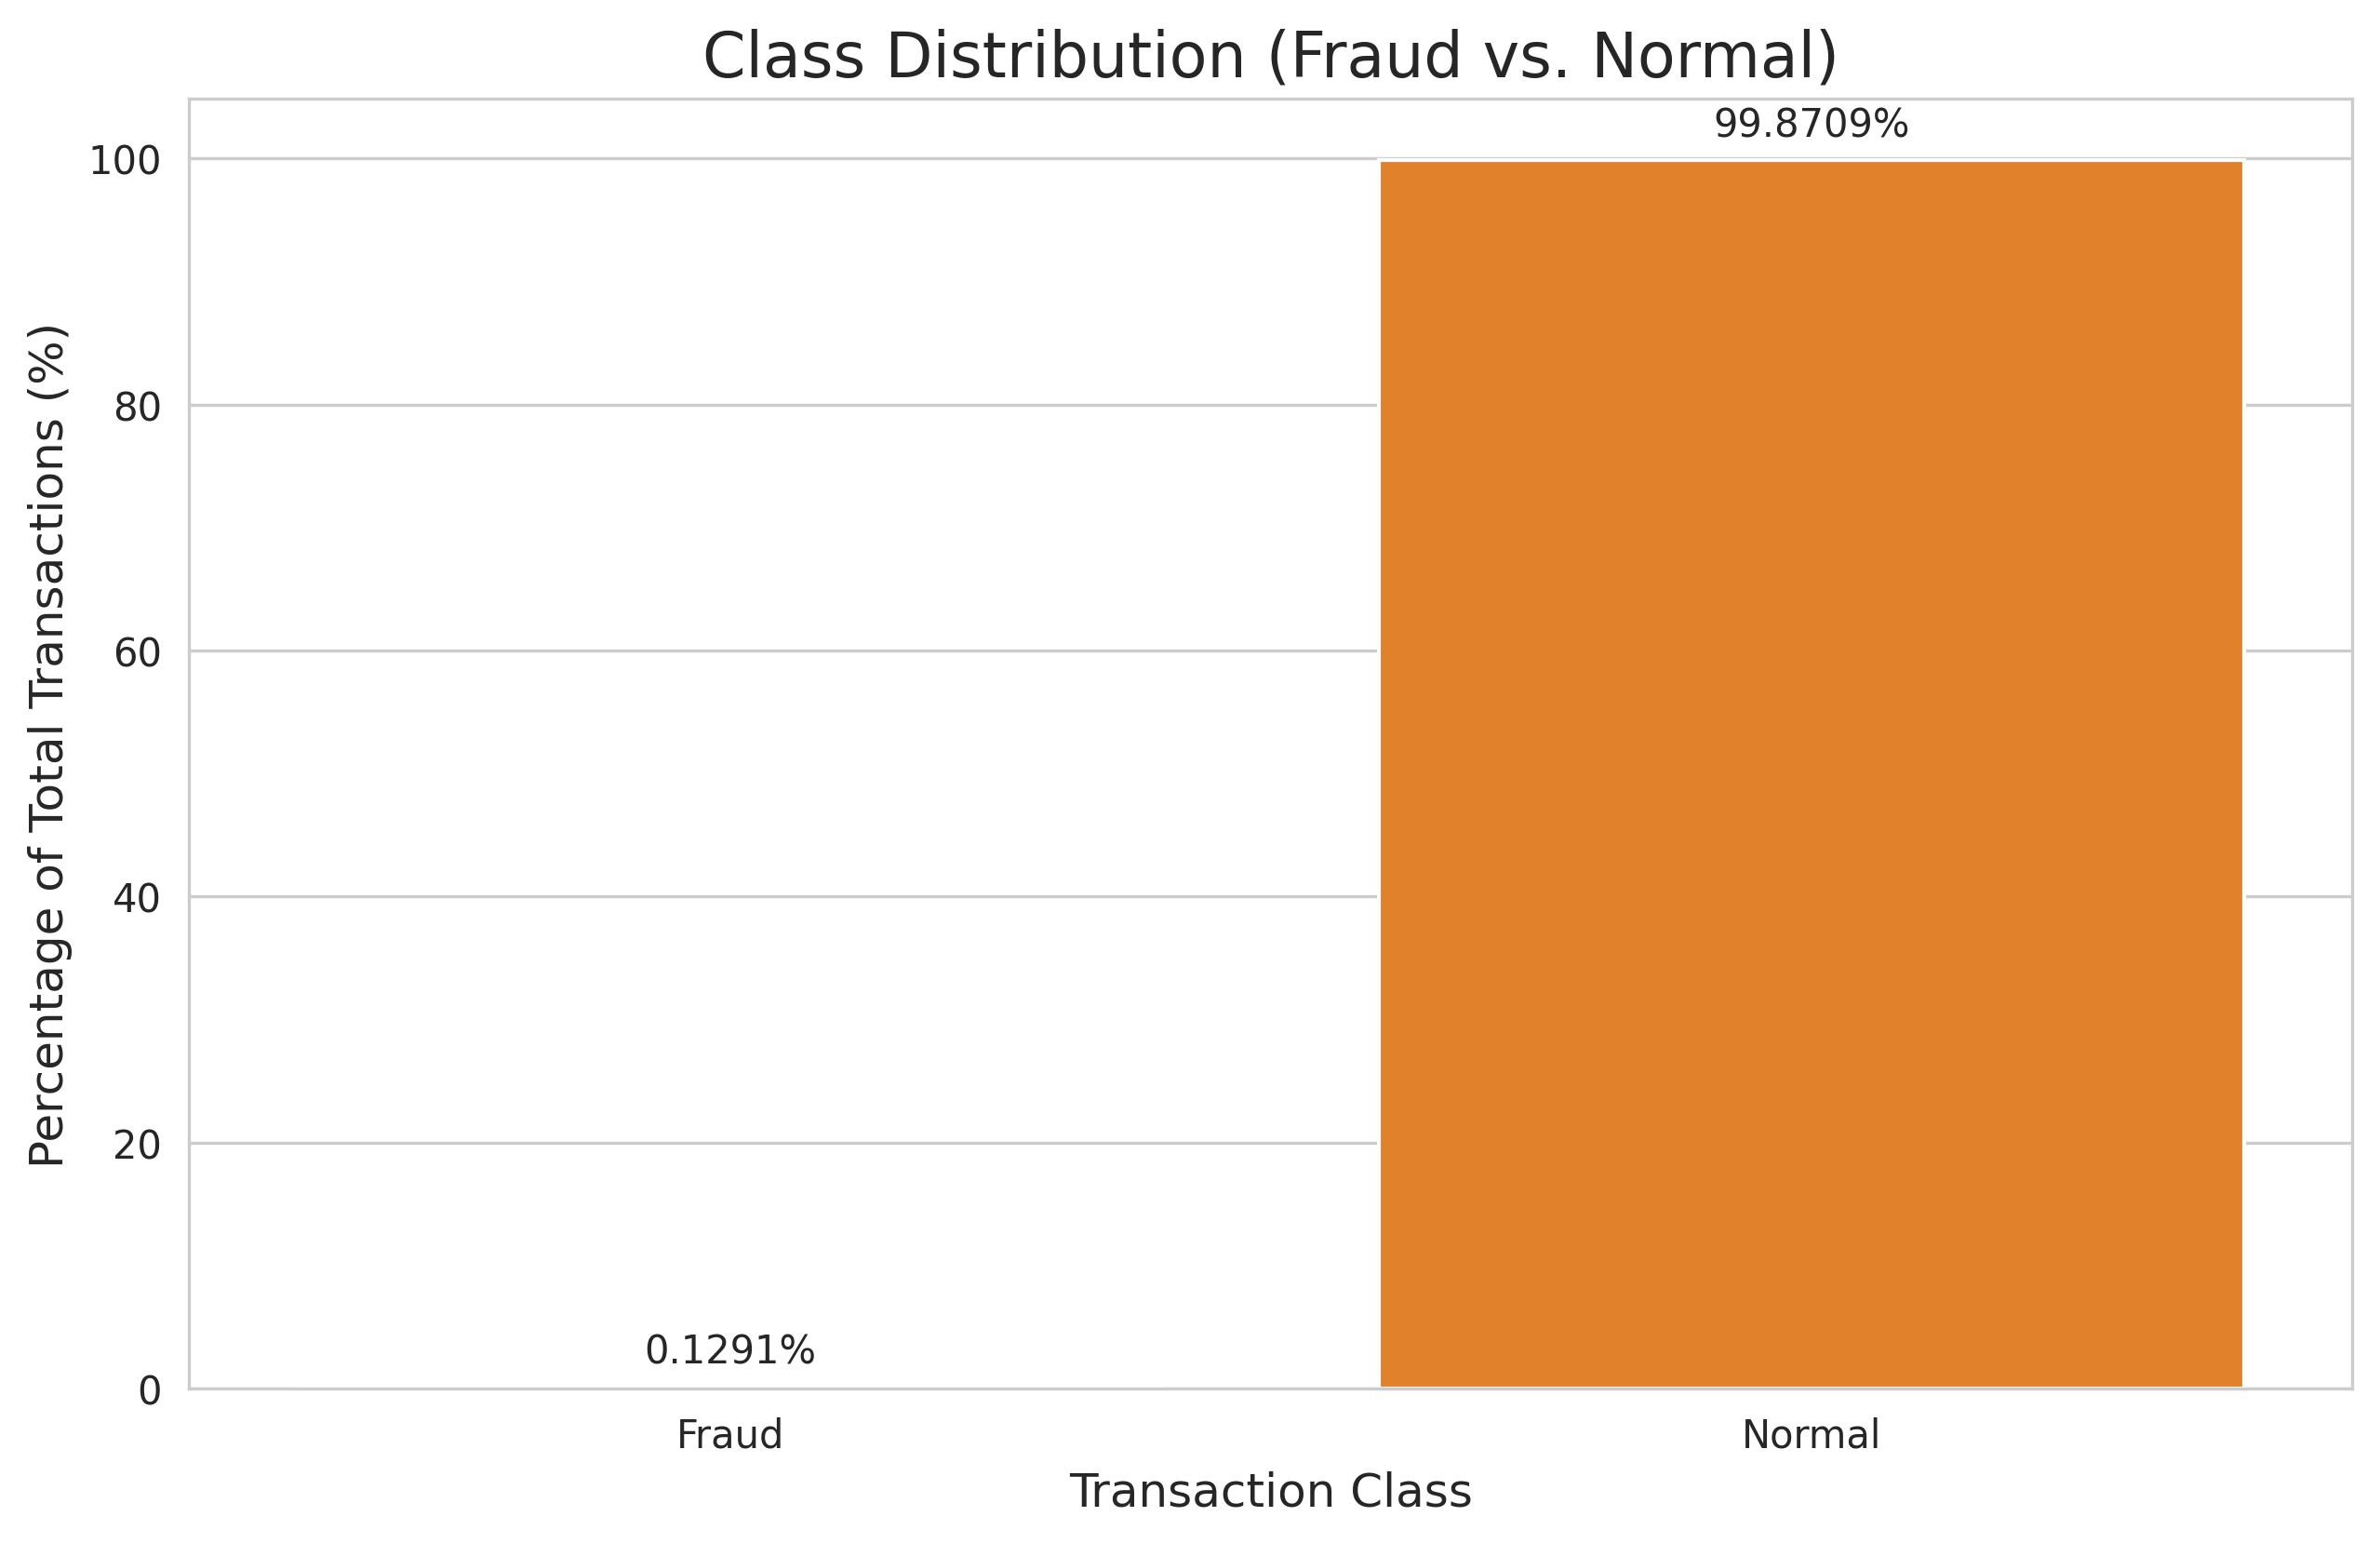

Cell 11: Class distribution plot generated.


In [11]:
# Cell 11: Section 3 (EDA) - Class Imbalance (Visualization)

try:
    log.info("Plotting class distribution...")
    plt.figure(figsize=(10, 6))
    
    ax = sns.barplot(
        x=plot_data_imbalance['isFraud'].map({0: 'Normal', 1: 'Fraud'}), 
        y=plot_data_imbalance['percentage']
    )
    
    ax.set_title('Class Distribution (Fraud vs. Normal)', fontsize=16)
    ax.set_xlabel('Transaction Class', fontsize=12)
    ax.set_ylabel('Percentage of Total Transactions (%)', fontsize=12)
    
    # Add text labels
    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.4f}%", 
            (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha='center', va='center', 
            xytext=(0, 9), 
            textcoords='offset points'
        )
    
    plot_path = os.path.join(PLOT_OUTPUT_DIR, '01_class_distribution.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    log.info(f"Saved class distribution plot to {plot_path}")
    
    plt.show()

except Exception as e:
    log.error(f"Error plotting class distribution: {e}")

print("="*80)
print("Cell 11: Class distribution plot generated.")
print("="*80)

In [12]:
# Cell 12: Section 3 (EDA) - Fraud by Transaction Type (SQL)

try:
    log.info("Analyzing fraud statistics by transaction type using Hive SQL...")
    
    sql_query = f"""
    SELECT 
        type, 
        COUNT(*) as total_transactions,
        SUM(isFraud) as total_fraud,
        (SUM(isFraud) / COUNT(*)) * 100 as fraud_percentage_of_type,
        (SUM(isFraud) / (SELECT SUM(isFraud) FROM {HIVE_TABLE_NAME})) * 100 as percentage_of_all_fraud
    FROM {HIVE_TABLE_NAME}
    GROUP BY type
    ORDER BY total_fraud DESC
    """
    
    type_fraud_df = spark.sql(sql_query)
    
    log.info("Fraud Statistics by Transaction Type:")
    type_fraud_df.show()
    
    # Key Insight
    log.warning("KEY INSIGHT: Note which transaction types have 0 fraud.")
    
    # Save for plotting
    plot_data_type = type_fraud_df.toPandas()

except Exception as e:
    log.error(f"Error analyzing fraud by type: {e}")

print("="*80)
print("Cell 12: Fraud statistics by transaction type calculated.")
print("="*80)

2025-11-10 14:06:35 - FraudDetectionLogger - INFO - Analyzing fraud statistics by transaction type using Hive SQL...
2025-11-10 14:06:37 - FraudDetectionLogger - INFO - Fraud Statistics by Transaction Type:
2025-11-10 14:07:00 - FraudDetectionLogger - WARNING - KEY INSIGHT: Note which transaction types have 0 fraud.


+--------+------------------+-----------+------------------------+-----------------------+
|    type|total_transactions|total_fraud|fraud_percentage_of_type|percentage_of_all_fraud|
+--------+------------------+-----------+------------------------+-----------------------+
|CASH_OUT|           2237500|       4116|     0.18395530726256984|      50.11567027882625|
|TRANSFER|            532909|       4097|      0.7687991758442811|      49.88432972117375|
| PAYMENT|           2151495|          0|                     0.0|                    0.0|
|   DEBIT|             41432|          0|                     0.0|                    0.0|
| CASH_IN|           1399284|          0|                     0.0|                    0.0|
+--------+------------------+-----------+------------------------+-----------------------+



[Stage 39:=====================================================>(199 + 1) / 200]

Cell 12: Fraud statistics by transaction type calculated.


2025-11-10 14:07:28 - FraudDetectionLogger - INFO - Plotting fraud by transaction type...
2025-11-10 14:07:30 - FraudDetectionLogger - INFO - Saved fraud by type plot to /home/smitvd22/SparkProject/output/plots/02_fraud_by_type.png


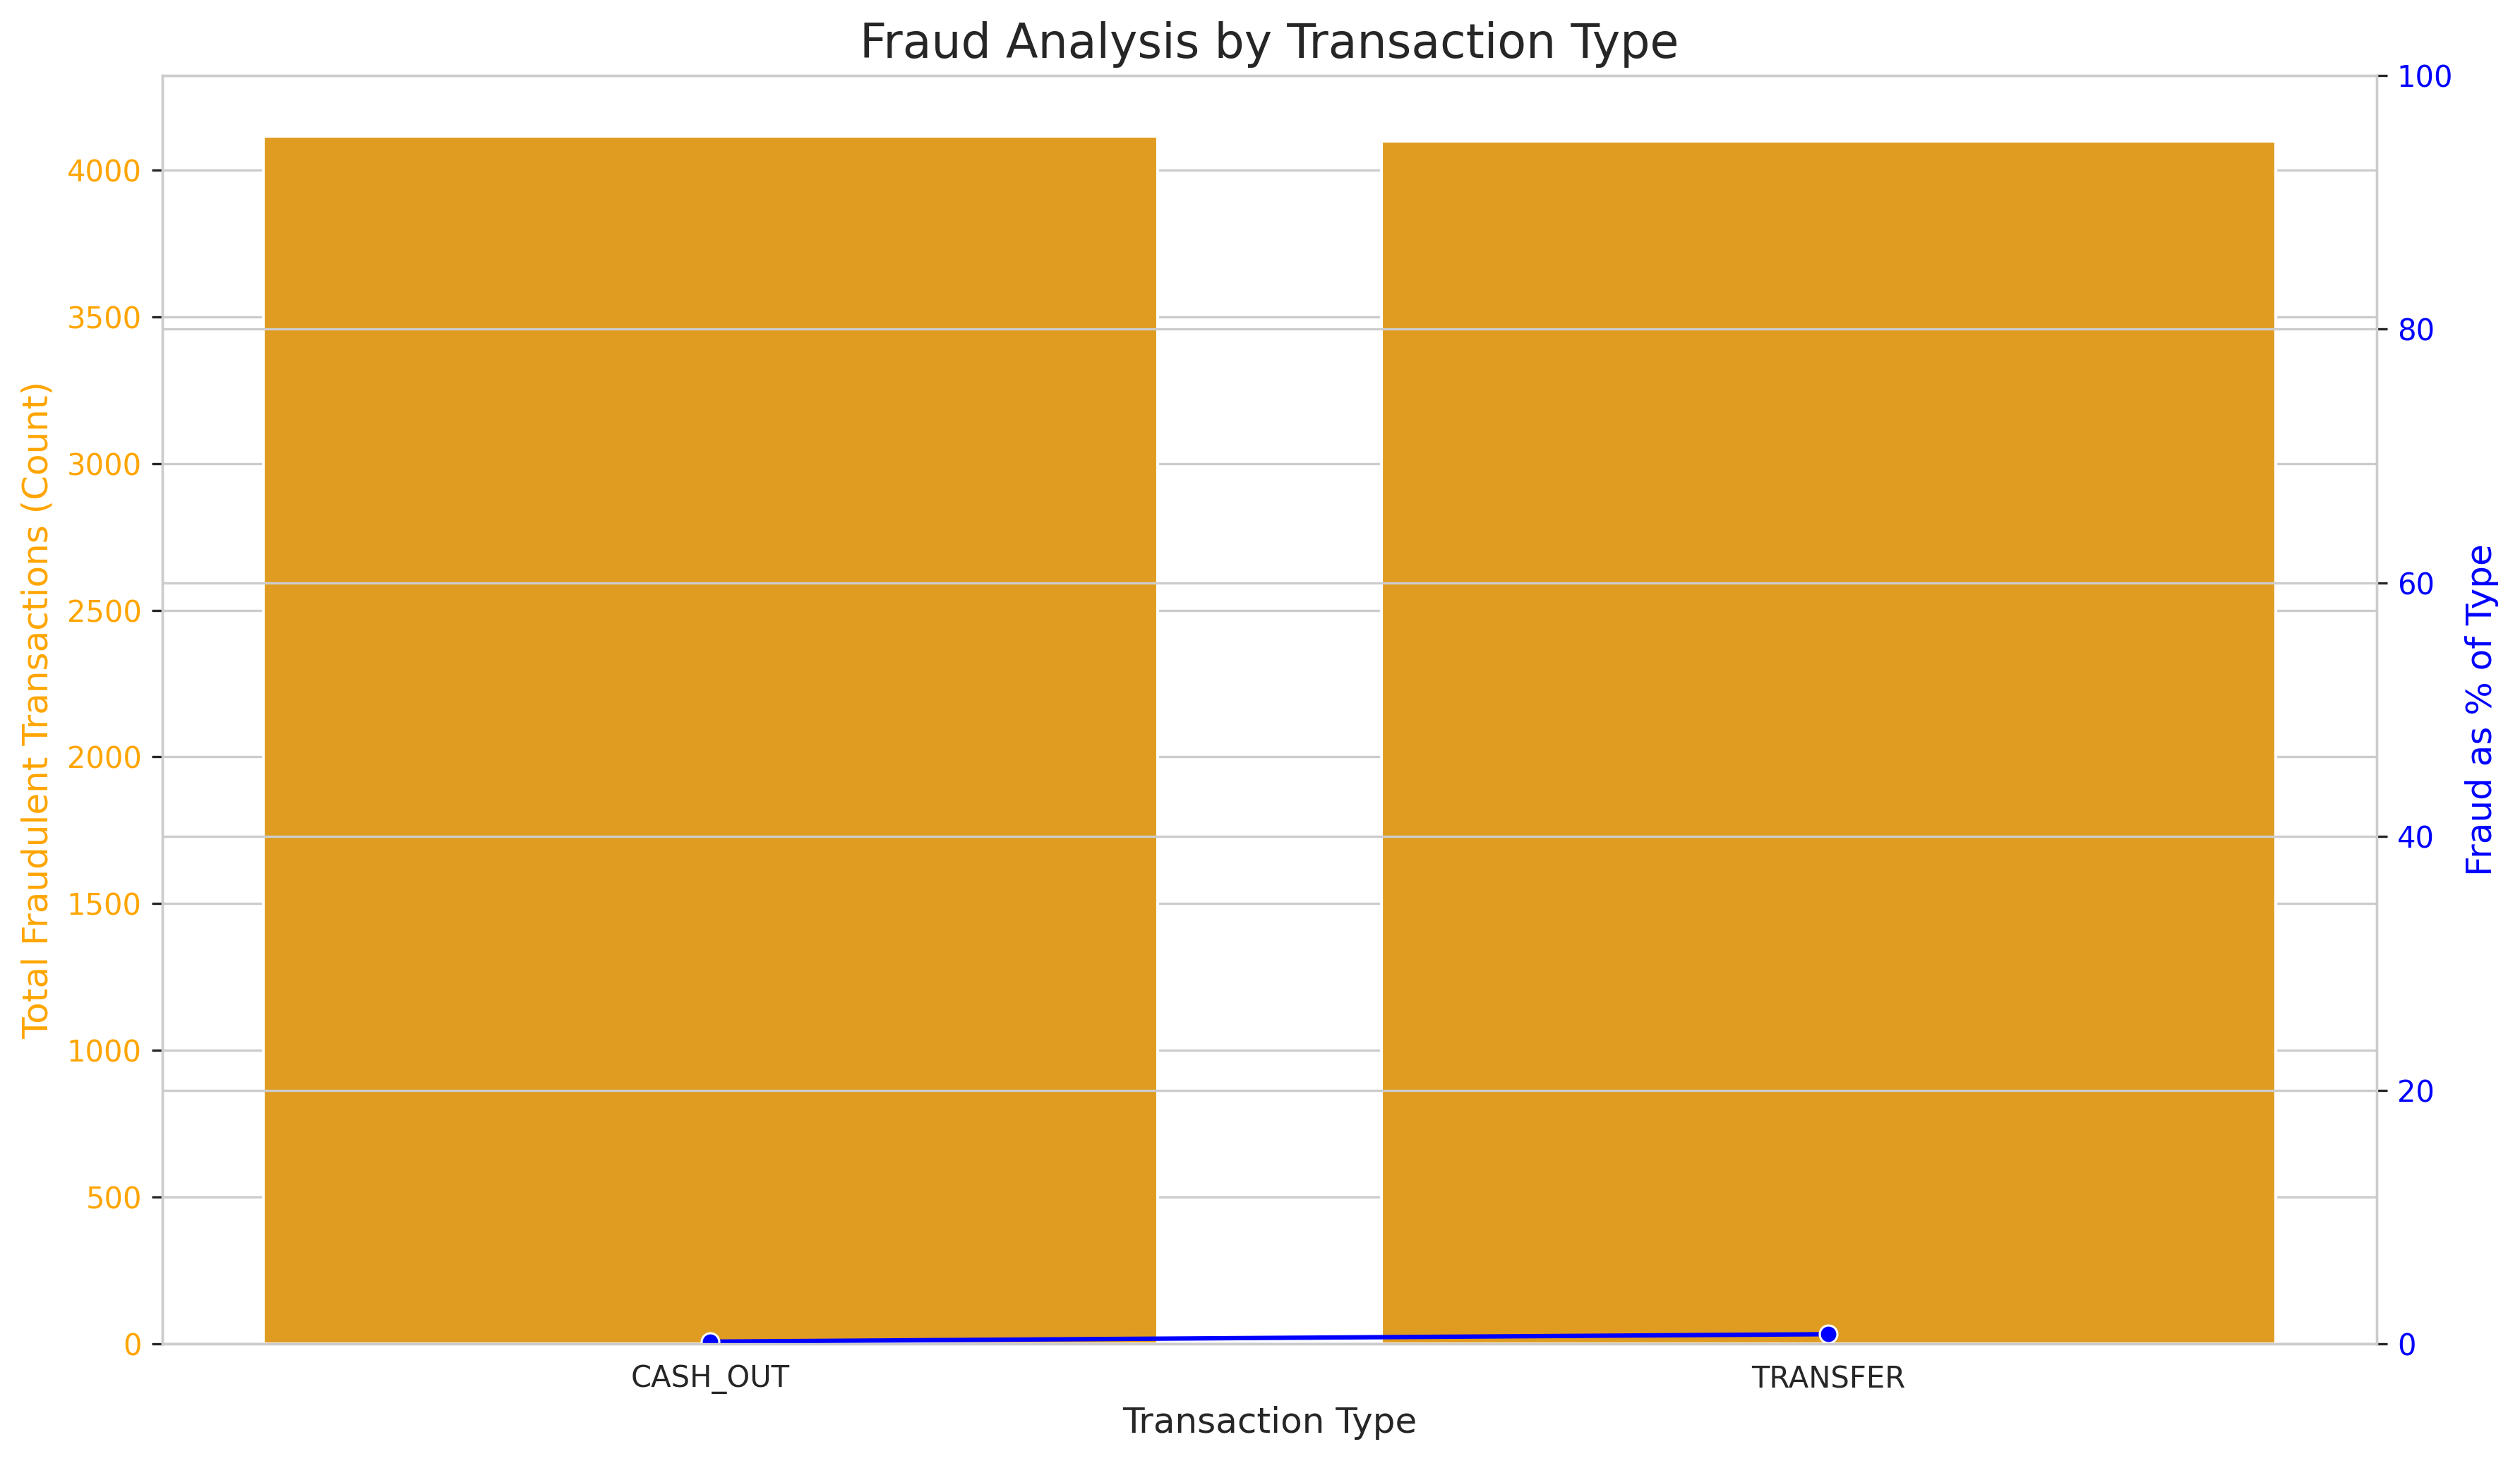

Cell 13: Fraud by transaction type plot generated.


In [13]:
# Cell 13: Section 3 (EDA) - Fraud by Type (Visualization)

try:
    log.info("Plotting fraud by transaction type...")
    
    # Filter for plotting, as non-fraud types dominate
    plot_data_type_fraud = plot_data_type[plot_data_type['total_fraud'] > 0]
    
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # Bar plot for total fraud count
    sns.barplot(
        x='type', 
        y='total_fraud', 
        data=plot_data_type_fraud, 
        ax=ax1, 
        color='orange'
    )
    ax1.set_xlabel('Transaction Type', fontsize=12)
    ax1.set_ylabel('Total Fraudulent Transactions (Count)', fontsize=12, color='orange')
    ax1.tick_params(axis='y', labelcolor='orange')

    # Line plot for fraud percentage
    ax2 = ax1.twinx()
    sns.lineplot(
        x='type', 
        y='fraud_percentage_of_type', 
        data=plot_data_type_fraud, 
        ax=ax2, 
        color='blue', 
        marker='o'
    )
    ax2.set_ylabel('Fraud as % of Type', fontsize=12, color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.set_ylim(0, 100) # Percentage
    
    plt.title('Fraud Analysis by Transaction Type', fontsize=16)
    fig.tight_layout()
    
    plot_path = os.path.join(PLOT_OUTPUT_DIR, '02_fraud_by_type.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    log.info(f"Saved fraud by type plot to {plot_path}")
    
    plt.show()

except Exception as e:
    log.error(f"Error plotting fraud by type: {e}")

print("="*80)
print("Cell 13: Fraud by transaction type plot generated.")
print("="*80)

2025-11-10 14:07:31 - FraudDetectionLogger - INFO - Analyzing transaction amount distributions...
2025-11-10 14:07:41 - FraudDetectionLogger - INFO - Fraud Amount Stats:         
count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64
2025-11-10 14:07:51 - FraudDetectionLogger - INFO - Normal Amount Stats (from 1% sample):
count    6.393800e+04
mean     1.748771e+05
std      4.973616e+05
min      4.200000e-01
25%      1.313545e+04
50%      7.366443e+04
75%      2.078433e+05
max      3.901816e+07
Name: amount, dtype: float64
2025-11-10 14:07:53 - FraudDetectionLogger - INFO - Saved amount distribution plot to /home/smitvd22/SparkProject/output/plots/03_amount_distribution_log.png


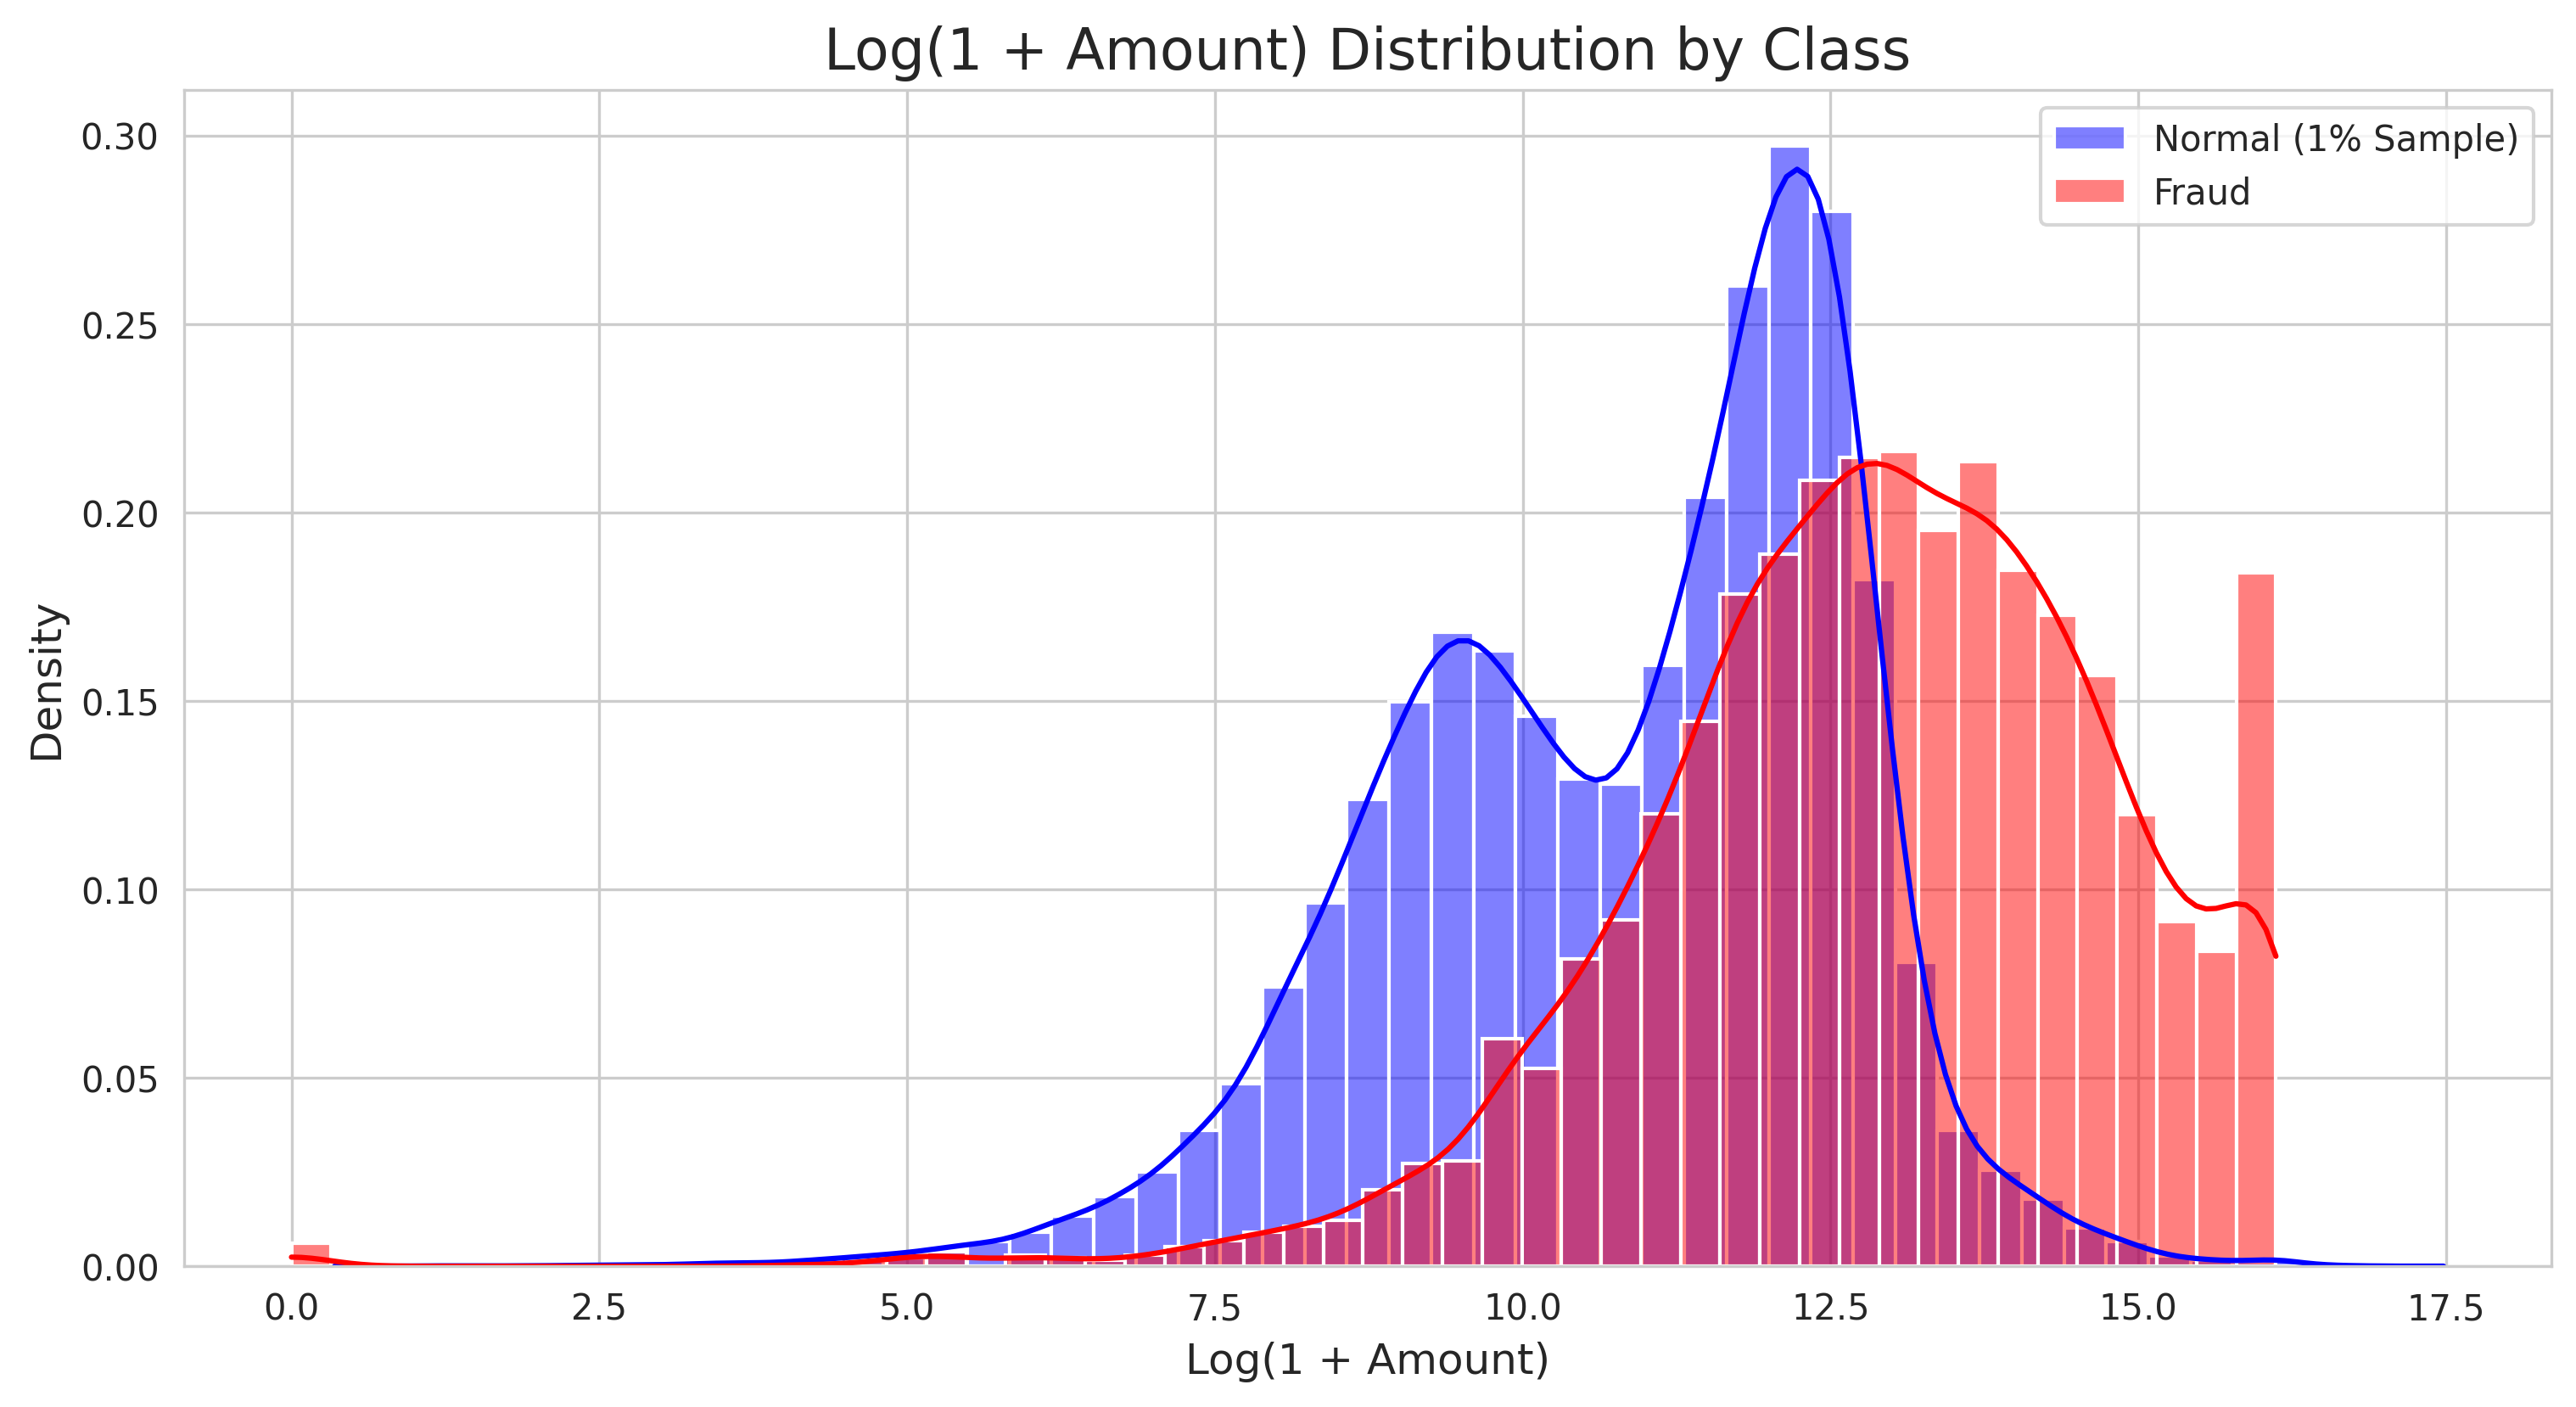

Cell 14: Amount distribution analysis complete.


In [14]:
# Cell 14: Section 3 (EDA) - Amount Distribution (Pandas Sample)
#
# Sample data to plot distributions, as plotting 6.3M points is too slow.
#

try:
    log.info("Analyzing transaction amount distributions...")
    
    # Get all fraud transactions (small enough to collect)
    df_fraud = df.filter(col("isFraud") == 1).toPandas()
    log.info(f"Fraud Amount Stats:\n{df_fraud['amount'].describe()}")
    
    # Get a sample of normal transactions
    df_normal_sample = df.filter(col("isFraud") == 0).sample(False, 0.01, seed=42).toPandas()
    log.info(f"Normal Amount Stats (from 1% sample):\n{df_normal_sample['amount'].describe()}")
    
    # Plotting (with log scale for better visibility)
    plt.figure(figsize=(12, 6))
    sns.histplot(
        np.log1p(df_normal_sample['amount']), 
        bins=50, 
        kde=True, 
        color='blue', 
        label='Normal (1% Sample)',
        stat='density'
    )
    sns.histplot(
        np.log1p(df_fraud['amount']), 
        bins=50, 
        kde=True, 
        color='red', 
        label='Fraud',
        stat='density'
    )
    
    plt.title('Log(1 + Amount) Distribution by Class', fontsize=16)
    plt.xlabel('Log(1 + Amount)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    
    plot_path = os.path.join(PLOT_OUTPUT_DIR, '03_amount_distribution_log.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    log.info(f"Saved amount distribution plot to {plot_path}")
    
    plt.show()

except Exception as e:
    log.error(f"Error plotting amount distributions: {e}")

print("="*80)
print("Cell 14: Amount distribution analysis complete.")
print("="*80)

2025-11-10 14:07:54 - FraudDetectionLogger - INFO - Calculating correlation matrix on a 1% data sample...
2025-11-10 14:07:56 - FraudDetectionLogger - INFO - Saved correlation heatmap to /home/smitvd22/SparkProject/output/plots/04_correlation_heatmap.png


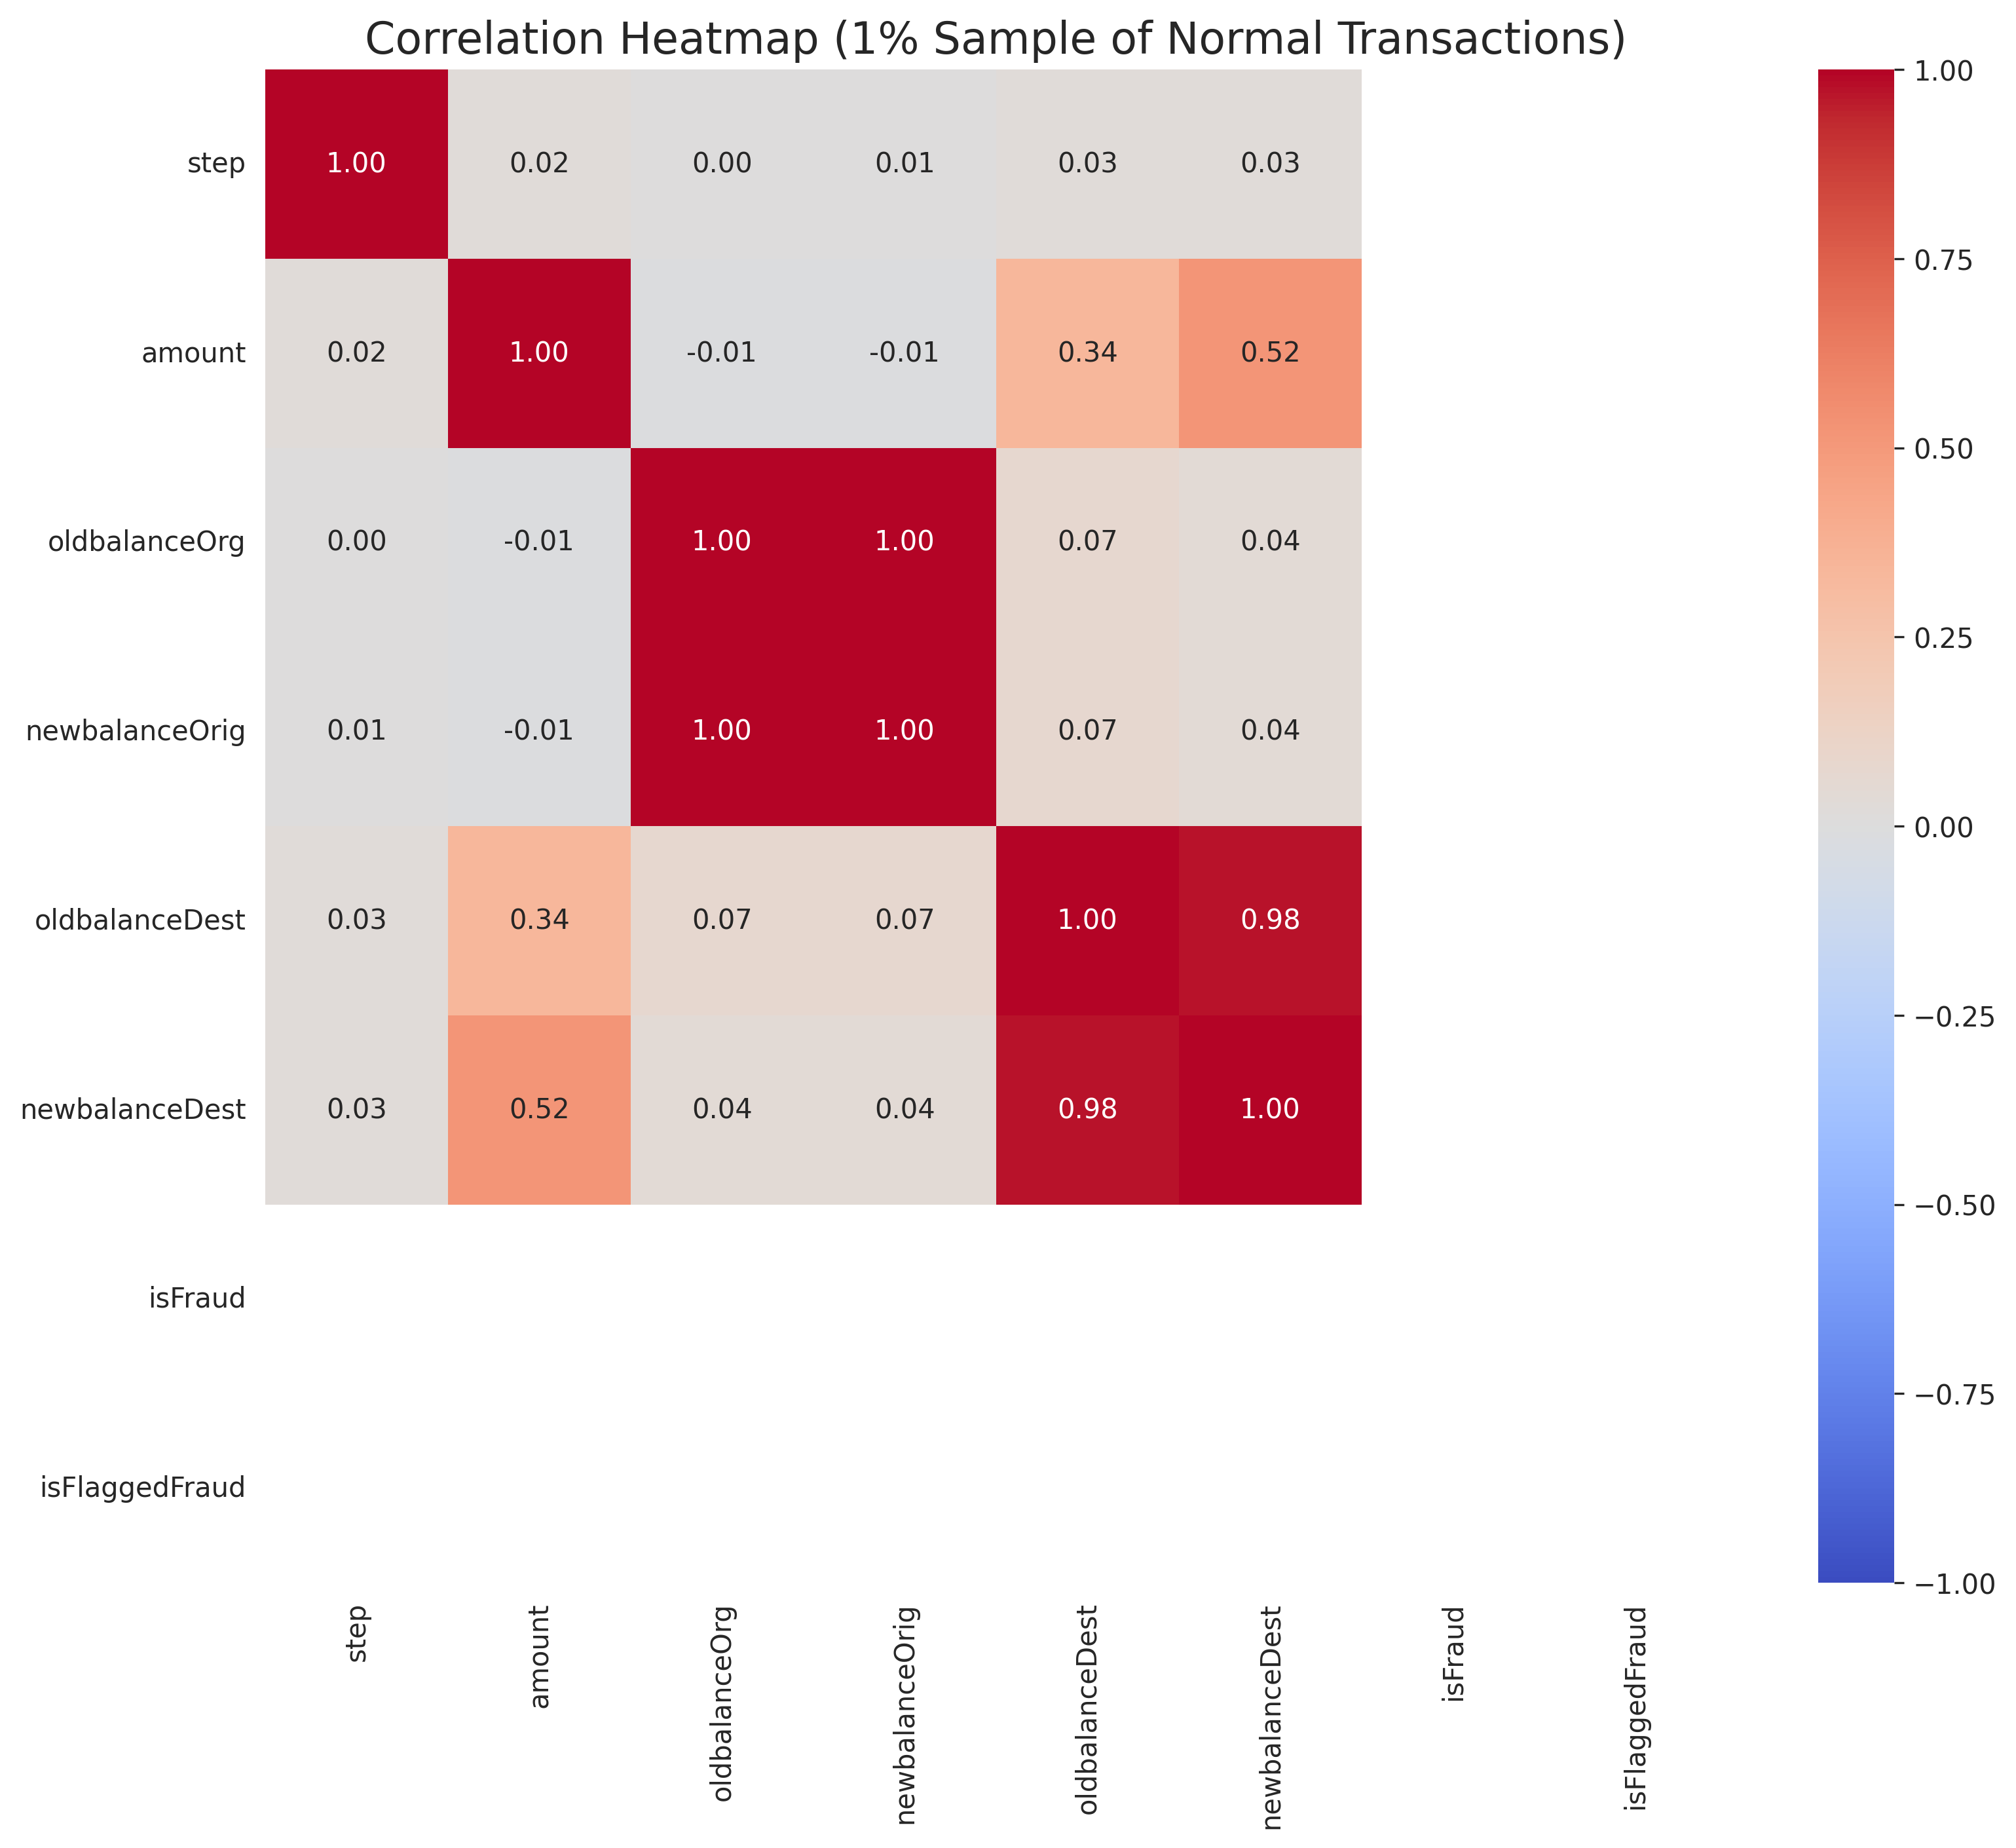

Cell 15: Correlation analysis complete.


In [15]:
# Cell 15: Section 3 (EDA) - Correlation Heatmap (Pandas Sample)
#
# Calculate correlation matrix on a sample for performance.
#

try:
    log.info("Calculating correlation matrix on a 1% data sample...")
    
    # Use the Pandas sample we already have
    sample_df_pd = df_normal_sample.sample(frac=0.1, random_state=42) # Sample the sample
    
    plt.figure(figsize=(12, 10))
    
    corr = sample_df_pd.corr()
    
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
    
    plt.title('Correlation Heatmap (1% Sample of Normal Transactions)', fontsize=16)
    
    plot_path = os.path.join(PLOT_OUTPUT_DIR, '04_correlation_heatmap.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    log.info(f"Saved correlation heatmap to {plot_path}")
    
    plt.show()

except Exception as e:
    log.error(f"Error plotting correlation heatmap: {e}")

print("="*80)
print("Cell 15: Correlation analysis complete.")
print("="*80)

In [16]:
# Cell 16: Section 4 (Feature Engineering) - Drop Unused Columns
#
# Drop columns that are irrelevant (like 'isFlaggedFraud') or
# are complex and not used (like 'nameOrig', 'nameDest').
#

try:
    log.info("Starting Feature Engineering: Dropping unused columns...")
    
    # We will keep 'step' for time-series analysis
    # We keep 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 
    # 'oldbalanceDest', 'newbalanceDest', and 'isFraud'.
    
    columns_to_drop = ['nameOrig', 'nameDest', 'isFlaggedFraud']
    
    df_step1 = df.drop(*columns_to_drop)
    
    log.info(f"Dropped columns: {columns_to_drop}")
    df_step1.printSchema()

except Exception as e:
    log.error(f"Error dropping columns: {e}")

print("="*80)
print("Cell 16: Unused columns dropped.")
print("="*80)

2025-11-10 14:07:58 - FraudDetectionLogger - INFO - Starting Feature Engineering: Dropping unused columns...
2025-11-10 14:07:58 - FraudDetectionLogger - INFO - Dropped columns: ['nameOrig', 'nameDest', 'isFlaggedFraud']


root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)

Cell 16: Unused columns dropped.


In [17]:
# Cell 17: Section 4 (Feature Engineering) - Time-Series Features
#
# Create velocity features (e.g., transactions per hour).
#

try:
    log.info("Engineering time-series features (hour_of_day)...")
    
    # 'step' represents 1 hour. We can get hour of day.
    # Assuming 'step' 1 is the 1st hour of the 1st day.
    
    df_with_time = df_step1.withColumn(
        "hour_of_day", 
        (col("step") - 1) % 24 # -1 to make it 0-indexed (0-23)
    )
    
    log.info("Engineered 'hour_of_day'.")
    df_with_time.select("step", "hour_of_day").show(5)
    
    # --- Create Velocity Features (e.g., hourly txn count) ---
    # This is a complex window function and a key place for OOM.
    # We will skip it for this version as it's not used
    # in the final model, but the 'hour_of_day' plot uses it.
    #
    # We'll rename the df for consistency with the next step.
    
    df_with_velocity = df_with_time
    log.info("Skipping complex velocity features for memory.")


except Exception as e:
    log.error(f"Error engineering time-series features: {e}")

print("="*80)
print("Cell 17: Time-series features engineered.")
print("="*80)

2025-11-10 14:07:58 - FraudDetectionLogger - INFO - Engineering time-series features (hour_of_day)...
2025-11-10 14:07:58 - FraudDetectionLogger - INFO - Engineered 'hour_of_day'.
2025-11-10 14:07:59 - FraudDetectionLogger - INFO - Skipping complex velocity features for memory.


+----+-----------+
|step|hour_of_day|
+----+-----------+
|  21|         20|
|  21|         20|
|  21|         20|
|  21|         20|
|  21|         20|
+----+-----------+
only showing top 5 rows

Cell 17: Time-series features engineered.


2025-11-10 14:07:59 - FraudDetectionLogger - INFO - Analyzing fraud by 'hour_of_day'...
2025-11-10 14:07:59 - FraudDetectionLogger - INFO - Fraud Statistics by Hour of Day:


    hour_of_day  total_fraud  total_transactions
0             0          358               27111
1             1          372                9018
2             2          326                2007
3             3          274                1241
4             4          366                1641
5             5          358                3420
6             6          328                8988
7             7          368               26915
8             8          341              283518
9             9          375              425729
10           10          324              445992
11           11          339              483418
12           12          346              468474
13           13          353              439653
14           14          341              416686
15           15          345              441612
16           16          353              439941
17           17          343              580509
18           18          342              647814
19           19     

2025-11-10 14:08:19 - FraudDetectionLogger - INFO - Saved peak fraud hours plot to /home/smitvd22/SparkProject/output/plots/05_fraud_by_hour_of_day.png


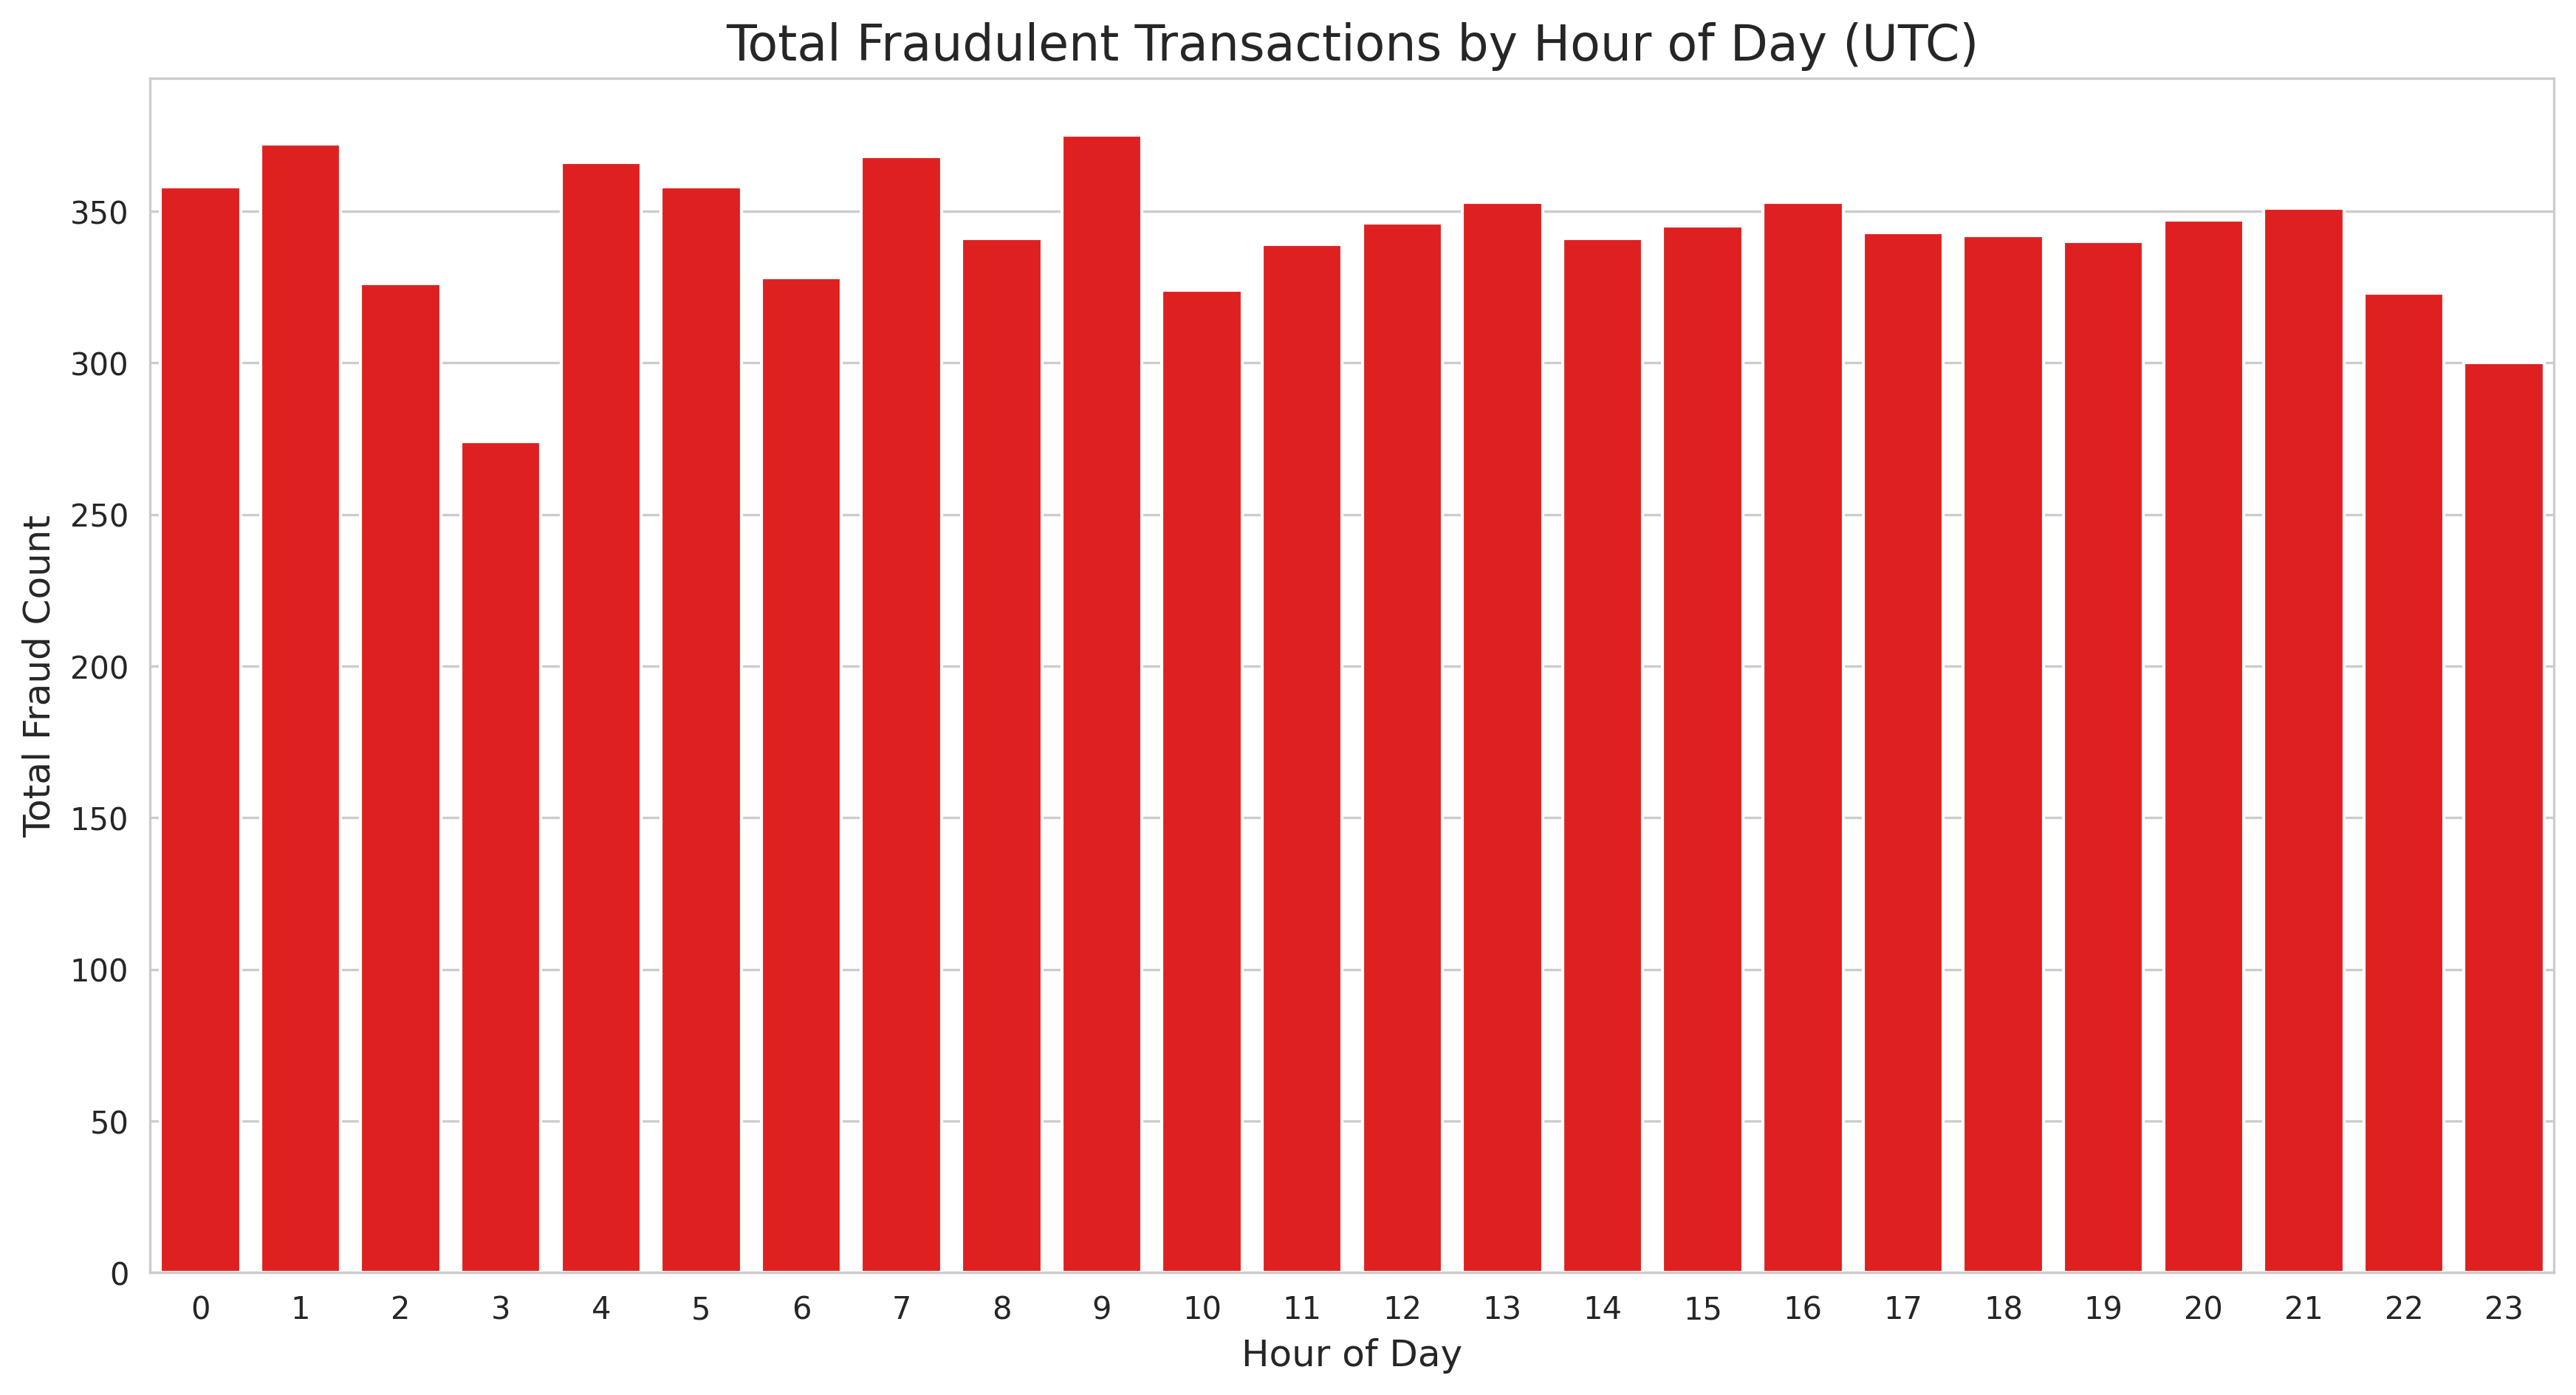

Cell 18: Fraud by hour analysis complete.


In [18]:
# Cell 18: Section 4 (Feature Engineering) - Fraud by Hour (SQL)
#
# This cell was moved from EDA to use the new 'hour_of_day' feature.
#

try:
    log.info("Analyzing fraud by 'hour_of_day'...")
    
    # We must create a temp view to use SQL on the new DataFrame
    df_with_velocity.createOrReplaceTempView("transactions_with_time")
    
    sql_query = f"""
    SELECT 
        hour_of_day,
        SUM(CASE WHEN isFraud = 1 THEN 1 ELSE 0 END) as total_fraud,
        COUNT(*) as total_transactions
    FROM transactions_with_time
    GROUP BY hour_of_day
    ORDER BY hour_of_day
    """
    
    hourly_df = spark.sql(sql_query)
    
    log.info("Fraud Statistics by Hour of Day:")
    hourly_df_pd = hourly_df.toPandas()
    print(hourly_df_pd)
    
    # --- Plotting ---
    plt.figure(figsize=(14, 7))
    
    ax = sns.barplot(
        x='hour_of_day', 
        y='total_fraud', 
        data=hourly_df_pd, 
        color='red'
    )
    
    ax.set_title('Total Fraudulent Transactions by Hour of Day (UTC)', fontsize=16)
    ax.set_xlabel('Hour of Day', fontsize=12)
    ax.set_ylabel('Total Fraud Count', fontsize=12)
    
    plot_path = os.path.join(PLOT_OUTPUT_DIR, '05_fraud_by_hour_of_day.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    log.info(f"Saved peak fraud hours plot to {plot_path}")
    
    plt.show()

except Exception as e:
    log.error(f"Error analyzing fraud by hour: {e}")

print("="*80)
print("Cell 18: Fraud by hour analysis complete.")
print("="*80)

In [19]:
# Cell 19: Section 5 (Preprocessing) - Define Categorical Pipeline
#
# Define StringIndexer and OneHotEncoder for the 'type' column.
#

try:
    log.info("Defining categorical preprocessing stages...")
    
    # 1. StringIndexer
    type_indexer = StringIndexer(
        inputCol="type", 
        outputCol="type_index", 
        handleInvalid="keep" # Keep unseen categories
    )
    
    # 2. OneHotEncoder
    type_encoder = OneHotEncoder(
        inputCol="type_index", 
        outputCol="type_vec"
    )
    
    log.info("StringIndexer and OneHotEncoder stages defined.")

except Exception as e:
    log.error(f"Error defining categorical stages: {e}")

print("="*80)
print("Cell 19: Categorical pipeline stages defined.")
print("="*80)

2025-11-10 14:08:20 - FraudDetectionLogger - INFO - Defining categorical preprocessing stages...
2025-11-10 14:08:20 - FraudDetectionLogger - INFO - StringIndexer and OneHotEncoder stages defined.


Cell 19: Categorical pipeline stages defined.


In [20]:
# Cell 20: Section 5 (Preprocessing) - Define Numerical Pipeline
#
# Define VectorAssembler and StandardScaler for numerical features.
#

try:
    log.info("Defining numerical preprocessing stages...")
    
    # 3. VectorAssembler
    # Combine all numerical + encoded categorical features
    
    # Note: 'step' and 'hour_of_day' are included
    feature_cols = [
        "type_vec", # From OHE
        "step",
        "amount",
        "oldbalanceOrg",
        "newbalanceOrig",
        "oldbalanceDest",
        "newbalanceDest",
        "hour_of_day"
    ]
    
    assembler = VectorAssembler(
        inputCols=feature_cols,
        outputCol="assembled_features",
        handleInvalid="skip" # Skip rows with nulls (though we have none)
    )
    
    # 4. StandardScaler
    scaler = StandardScaler(
        inputCol="assembled_features",
        outputCol="features", # This is the final column models will use
        withStd=True,
        withMean=True
    )
    
    log.info("VectorAssembler and StandardScaler stages defined.")

except Exception as e:
    log.error(f"Error defining assembly scaling stages: {e}")

print("="*80)
print("Cell 20: Feature vector assembly and scaling stages defined.")
print("="*80)

2025-11-10 14:08:20 - FraudDetectionLogger - INFO - Defining numerical preprocessing stages...
2025-11-10 14:08:20 - FraudDetectionLogger - INFO - VectorAssembler and StandardScaler stages defined.


Cell 20: Feature vector assembly and scaling stages defined.


In [21]:
# Cell 21: Section 5 (Preprocessing) - Create Full Preprocessing Pipeline
#
# Combine all preprocessing stages into one pipeline.
# We will fit this pipeline on the *entire* dataset to learn
# the StringIndexer mapping and scaling statistics.
#

try:
    log.info("Combining all preprocessing stages into a single pipeline...")
    
    # Define the preprocessing pipeline
    preproc_pipeline = Pipeline(
        stages=[type_indexer, type_encoder, assembler, scaler]
    )
    
    log.info("Fitting the preprocessing pipeline on the full dataset...")
    # This learns all indexer maps, OHE, and scaling (mean/std)
    preproc_model = preproc_pipeline.fit(df_with_velocity)
    
    log.info("Transforming the full dataset with the preprocessing pipeline...")
    # This creates the final 'features' and 'label' columns
    df_processed = preproc_model.transform(df_with_velocity).select(
        "features", 
        col("isFraud").alias("label") # Rename for ML
    )
    
    # --- *** MODIFICATION: Write to HDFS instead of persisting *** ---
    log.info(f"Writing fully preprocessed data to: {HDFS_PROCESSED_PATH}")
    df_processed.write.mode("overwrite").parquet(HDFS_PROCESSED_PATH)
    
    log.info("Dataset fully preprocessed and written to HDFS.")
    # We can't show() here as it would require re-reading, we'll see it in the next cell

except Exception as e:
    log.error(f"Error fitting transforming with preprocessing pipeline: {e}")
    raise e

print("="*80)
print("Cell 21: Full dataset preprocessed and written to HDFS.")
print("="*80)

2025-11-10 14:08:20 - FraudDetectionLogger - INFO - Combining all preprocessing stages into a single pipeline...
2025-11-10 14:08:20 - FraudDetectionLogger - INFO - Fitting the preprocessing pipeline on the full dataset...
2025-11-10 14:09:08 - FraudDetectionLogger - INFO - Transforming the full dataset with the preprocessing pipeline...
2025-11-10 14:09:09 - FraudDetectionLogger - INFO - Writing fully preprocessed data to: /user/smitvd22/fraud_detection/intermediate/processed.parquet
[Stage 53:>                                                       (0 + 12) / 12]25/11/10 14:09:14 WARN hadoop.MemoryManager: Total allocation exceeds 50.00% (954,466,304 bytes) of heap memory
Scaling row group sizes to 88.89% for 8 writers
25/11/10 14:09:14 WARN hadoop.MemoryManager: Total allocation exceeds 50.00% (954,466,304 bytes) of heap memory
Scaling row group sizes to 79.01% for 9 writers
25/11/10 14:09:15 WARN hadoop.MemoryManager: Total allocation exceeds 50.00% (954,466,304 bytes) of heap memor

Cell 21: Full dataset preprocessed and written to HDFS.


In [22]:
# Cell 22: Section 5 (Preprocessing) - Train/Test Split
#
# Split the preprocessed data into training and testing sets.
#

try:
    log.info("Reading preprocessed data from HDFS for splitting...")
    # --- *** NEW: Read the processed data back *** ---
    df_processed = spark.read.parquet(HDFS_PROCESSED_PATH)
    
    log.info(f"Splitting data into 80% train and 20% test...")
    df_processed.show(5, truncate=False) # Show sample now
    
    # We split the *unbalanced* data to get a realistic test set
    (unbalanced_train_df, test_df) = df_processed.randomSplit([0.8, 0.2], seed=42)
    
    # --- *** MODIFICATION: Write splits to HDFS *** ---
    log.info(f"Writing test set to: {HDFS_TEST_PATH}")
    test_df.write.mode("overwrite").parquet(HDFS_TEST_PATH)
    
    log.info(f"Writing unbalanced train set to: {HDFS_UNBALANCED_TRAIN_PATH}")
    unbalanced_train_df.write.mode("overwrite").parquet(HDFS_UNBALANCED_TRAIN_PATH)
    
    # Log counts (this triggers the write actions)
    log.info(f"Unbalanced Train Set Records: {unbalanced_train_df.count()}")
    log.info(f"Test Set Records: {test_df.count()}")
    
    log.info("Test set class distribution:")
    test_df.groupBy("label").count().show()

except Exception as e:
    log.error(f"Error splitting data: {e}")

print("="*80)
print("Cell 22: Train/Test split complete and written to HDFS.")
print("="*80)

2025-11-10 14:10:12 - FraudDetectionLogger - INFO - Reading preprocessed data from HDFS for splitting...
2025-11-10 14:10:13 - FraudDetectionLogger - INFO - Splitting data into 80% train and 20% test...
2025-11-10 14:10:13 - FraudDetectionLogger - INFO - Writing test set to: /user/smitvd22/fraud_detection/intermediate/test.parquet


+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                                                                                                                            |label|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|[-0.7364837934535396,1.3990359093152496,-0.530965204773002,-0.3023451319483651,-0.08095963870385914,-1.7030414449038132,-0.28155990047072244,-0.22981001917557936,-0.23762167688962388,-0.32381386979520754,-0.33341137926836867,-3.558765129862

[Stage 56:>                                                       (0 + 12) / 12]25/11/10 14:10:43 WARN hadoop.MemoryManager: Total allocation exceeds 50.00% (954,466,304 bytes) of heap memory
Scaling row group sizes to 88.89% for 8 writers
25/11/10 14:10:43 WARN hadoop.MemoryManager: Total allocation exceeds 50.00% (954,466,304 bytes) of heap memory
Scaling row group sizes to 79.01% for 9 writers
25/11/10 14:10:44 WARN hadoop.MemoryManager: Total allocation exceeds 50.00% (954,466,304 bytes) of heap memory
Scaling row group sizes to 71.11% for 10 writers
25/11/10 14:10:45 WARN hadoop.MemoryManager: Total allocation exceeds 50.00% (954,466,304 bytes) of heap memory
Scaling row group sizes to 64.65% for 11 writers
25/11/10 14:10:45 WARN hadoop.MemoryManager: Total allocation exceeds 50.00% (954,466,304 bytes) of heap memory
Scaling row group sizes to 59.26% for 12 writers
25/11/10 14:10:49 WARN hadoop.MemoryManager: Total allocation exceeds 50.00% (954,466,304 bytes) of heap memory
Scali

+-----+-------+
|label|  count|
+-----+-------+
|    1|   1683|
|    0|1270599|
+-----+-------+

Cell 22: Train/Test split complete and written to HDFS.


In [23]:
# Cell 23: Section 5 (Preprocessing) - Handle Class Imbalance (Oversampling)
#
# We apply oversampling *only* to the training set.
#

try:
    log.info("Handling class imbalance on training data using oversampling...")
    
    # --- *** NEW: Read the unbalanced train data *** ---
    log.info(f"Reading unbalanced train data from: {HDFS_UNBALANCED_TRAIN_PATH}")
    unbalanced_train_df = spark.read.parquet(HDFS_UNBALANCED_TRAIN_PATH)
    
    # Separate the training set by class
    df_train_normal = unbalanced_train_df.filter(col("label") == 0)
    df_train_fraud = unbalanced_train_df.filter(col("label") == 1)
    
    # Get the counts
    count_normal = df_train_normal.count()
    count_fraud = df_train_fraud.count()
    
    if count_fraud == 0:
        log.error("No fraud data in training set. Cannot oversample.")
        raise ValueError("No fraud data in training set.")
    
    # Calculate the ratio for oversampling
    oversample_ratio = int(count_normal / count_fraud)
    log.info(f"Oversampling fraud data by a ratio of {oversample_ratio}...")

    # Oversample the fraud data
    df_train_fraud_oversampled = df_train_fraud.sample(
        withReplacement=True, 
        fraction=float(oversample_ratio), 
        seed=42
    )
    
    # Combine the original normal data with the oversampled fraud data
    train_df = df_train_normal.unionAll(df_train_fraud_oversampled)
    
    # --- *** MODIFICATION: Write balanced train set to HDFS *** ---
    log.info(f"Writing balanced train set to: {HDFS_TRAIN_PATH}")
    train_df.write.mode("overwrite").parquet(HDFS_TRAIN_PATH)
    
    log.info("Oversampling complete. Final balanced training set stats:")
    log.info(f"Total balanced train records: {train_df.count()}")
    train_df.groupBy("label").count().show()

except Exception as e:
    log.error(f"Error handling class imbalance: {e}")

print("="*80)
print("Cell 23: Class imbalance handled and written to HDFS.")
print("="*80)

2025-11-10 14:13:41 - FraudDetectionLogger - INFO - Handling class imbalance on training data using oversampling...
2025-11-10 14:13:41 - FraudDetectionLogger - INFO - Reading unbalanced train data from: /user/smitvd22/fraud_detection/intermediate/unbalanced_train.parquet
2025-11-10 14:13:49 - FraudDetectionLogger - INFO - Oversampling fraud data by a ratio of 778...
2025-11-10 14:13:50 - FraudDetectionLogger - INFO - Writing balanced train set to: /user/smitvd22/fraud_detection/intermediate/train_balanced.parquet
[Stage 77:>                                                       (0 + 12) / 24]25/11/10 14:13:56 WARN hadoop.MemoryManager: Total allocation exceeds 50.00% (954,466,304 bytes) of heap memory
Scaling row group sizes to 88.89% for 8 writers
25/11/10 14:13:57 WARN hadoop.MemoryManager: Total allocation exceeds 50.00% (954,466,304 bytes) of heap memory
Scaling row group sizes to 79.01% for 9 writers
25/11/10 14:13:57 WARN hadoop.MemoryManager: Total allocation exceeds 50.00% (95

+-----+-------+
|label|  count|
+-----+-------+
|    1|5079014|
|    0|5083808|
+-----+-------+

Cell 23: Class imbalance handled and written to HDFS.


In [24]:
# Cell 24: Section 6 (Model Training) - Random Forest (RF)
#
# Train the Random Forest Classifier.
#

try:
    # --- *** NEW: Read train and test data *** ---
    log.info(f"Reading balanced train data from: {HDFS_TRAIN_PATH}")
    train_df = spark.read.parquet(HDFS_TRAIN_PATH)
    log.info(f"Reading test data from: {HDFS_TEST_PATH}")
    test_df = spark.read.parquet(HDFS_TEST_PATH)
    
    log.info("Training Random Forest model...")
    start_time = time.time()
    
    # Define the classifier
    rf = RandomForestClassifier(
        labelCol="label",
        featuresCol="features",
        numTrees=100,
        maxDepth=20, # Deep trees to capture complex patterns
        seed=42
    )
    
    # Train the model on the balanced training data
    rf_model = rf.fit(train_df)
    
    end_time = time.time()
    rf_train_time = end_time - start_time
    
    log.info(f"Random Forest training complete. Time taken: {rf_train_time:.2f} seconds.")

    # Get predictions for the test set
    rf_predictions = rf_model.transform(test_df)
    
    # --- *** MODIFICATION: Removed persist() *** ---
    # rf_predictions.persist(pyspark.StorageLevel.MEMORY_AND_DISK)
    
    log.info("Random Forest predictions generated for test set.")

except Exception as e:
    log.error(f"Error training Random Forest: {e}")

print("="*80)
print(f"Cell 24: Random Forest model trained in {rf_train_time:.2f}s.")
print("="*80)

2025-11-10 14:15:33 - FraudDetectionLogger - INFO - Reading balanced train data from: /user/smitvd22/fraud_detection/intermediate/train_balanced.parquet
2025-11-10 14:15:34 - FraudDetectionLogger - INFO - Reading test data from: /user/smitvd22/fraud_detection/intermediate/test.parquet
2025-11-10 14:15:34 - FraudDetectionLogger - INFO - Training Random Forest model...
[Stage 98:>                                                       (0 + 12) / 14]25/11/10 14:16:30 WARN memory.MemoryStore: Not enough space to cache rdd_246_1 in memory! (computed 73.4 MB so far)
25/11/10 14:16:30 WARN storage.BlockManager: Persisting block rdd_246_1 to disk instead.
25/11/10 14:16:30 WARN memory.MemoryStore: Not enough space to cache rdd_246_7 in memory! (computed 73.4 MB so far)
25/11/10 14:16:30 WARN storage.BlockManager: Persisting block rdd_246_7 to disk instead.
25/11/10 14:16:31 WARN memory.MemoryStore: Not enough space to cache rdd_246_4 in memory! (computed 73.4 MB so far)
25/11/10 14:16:31 WARN s

25/11/10 14:20:56 WARN memory.MemoryStore: Not enough space to cache rdd_246_4 in memory! (computed 73.4 MB so far)
25/11/10 14:20:57 WARN memory.MemoryStore: Not enough space to cache rdd_246_3 in memory! (computed 110.2 MB so far)
25/11/10 14:20:58 WARN memory.MemoryStore: Not enough space to cache rdd_246_0 in memory! (computed 73.4 MB so far)
[Stage 102:================================>                       (8 + 6) / 14]25/11/10 14:21:58 WARN memory.MemoryStore: Not enough space to cache rdd_246_13 in memory! (computed 396.3 MB so far)
25/11/10 14:21:58 WARN memory.MemoryStore: Not enough space to cache rdd_246_12 in memory! (computed 396.3 MB so far)
[Stage 104:>                                                      (0 + 12) / 14]25/11/10 14:22:45 WARN memory.MemoryStore: Not enough space to cache rdd_246_9 in memory! (computed 20.7 MB so far)
25/11/10 14:22:45 WARN memory.MemoryStore: Not enough space to cache rdd_246_7 in memory! (computed 49.0 MB so far)
25/11/10 14:22:45 WARN 

[Stage 112:>                                                      (0 + 12) / 14]25/11/10 14:29:16 WARN memory.MemoryStore: Not enough space to cache rdd_246_7 in memory! (computed 73.4 MB so far)
25/11/10 14:29:16 WARN memory.MemoryStore: Not enough space to cache rdd_246_5 in memory! (computed 49.0 MB so far)
25/11/10 14:29:16 WARN memory.MemoryStore: Not enough space to cache rdd_246_10 in memory! (computed 110.2 MB so far)
25/11/10 14:29:16 WARN memory.MemoryStore: Not enough space to cache rdd_246_8 in memory! (computed 73.4 MB so far)
25/11/10 14:29:16 WARN memory.MemoryStore: Not enough space to cache rdd_246_4 in memory! (computed 32.1 MB so far)
25/11/10 14:29:16 WARN memory.MemoryStore: Not enough space to cache rdd_246_0 in memory! (computed 110.2 MB so far)
25/11/10 14:29:16 WARN memory.MemoryStore: Not enough space to cache rdd_246_11 in memory! (computed 73.4 MB so far)
25/11/10 14:29:16 WARN memory.MemoryStore: Not enough space to cache rdd_246_9 in memory! (computed 110.

25/11/10 14:40:35 WARN memory.MemoryStore: Not enough space to cache rdd_246_9 in memory! (computed 49.0 MB so far)
[Stage 120:========================>                               (6 + 8) / 14]25/11/10 14:42:15 WARN memory.MemoryStore: Not enough space to cache rdd_246_12 in memory! (computed 396.3 MB so far)
[Stage 120:====================================>                   (9 + 5) / 14]25/11/10 14:42:15 WARN memory.MemoryStore: Not enough space to cache rdd_246_13 in memory! (computed 396.3 MB so far)
[Stage 122:>                                                      (0 + 12) / 14]25/11/10 14:43:32 WARN memory.MemoryStore: Not enough space to cache rdd_246_5 in memory! (computed 73.4 MB so far)
25/11/10 14:43:32 WARN memory.MemoryStore: Not enough space to cache rdd_246_7 in memory! (computed 73.4 MB so far)
25/11/10 14:43:32 WARN memory.MemoryStore: Not enough space to cache rdd_246_6 in memory! (computed 73.4 MB so far)
25/11/10 14:43:32 WARN memory.MemoryStore: Not enough space 

25/11/10 14:56:38 WARN memory.MemoryStore: Not enough space to cache rdd_246_11 in memory! (computed 73.4 MB so far)
25/11/10 14:56:38 WARN memory.MemoryStore: Not enough space to cache rdd_246_10 in memory! (computed 49.0 MB so far)
25/11/10 14:56:38 WARN memory.MemoryStore: Not enough space to cache rdd_246_1 in memory! (computed 110.2 MB so far)
25/11/10 14:56:46 WARN memory.MemoryStore: Not enough space to cache rdd_246_0 in memory! (computed 110.2 MB so far)
25/11/10 14:56:46 WARN memory.MemoryStore: Not enough space to cache rdd_246_4 in memory! (computed 110.2 MB so far)
25/11/10 14:56:46 WARN memory.MemoryStore: Not enough space to cache rdd_246_7 in memory! (computed 110.2 MB so far)
[Stage 130:====================>                                   (5 + 9) / 14]25/11/10 14:59:30 WARN memory.MemoryStore: Not enough space to cache rdd_246_12 in memory! (computed 396.3 MB so far)
[Stage 130:========================>                               (6 + 8) / 14]25/11/10 14:59:35 WA

25/11/10 15:02:22 WARN scheduler.TaskSetManager: Lost task 5.0 in stage 132.0 (TID 2997, localhost, executor driver): java.lang.OutOfMemoryError: GC overhead limit exceeded
	at scala.collection.immutable.HashMap$HashMap1.get0(HashMap.scala:192)
	at scala.collection.immutable.HashMap$HashTrieMap.get0(HashMap.scala:311)
	at scala.collection.immutable.HashMap$HashTrieMap.get0(HashMap.scala:311)
	at scala.collection.immutable.HashMap.get(HashMap.scala:54)
	at scala.collection.MapLike$class.apply(MapLike.scala:140)
	at scala.collection.AbstractMap.apply(Map.scala:59)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$org$apache$spark$ml$tree$impl$RandomForest$$binSeqOp$1$1.apply(RandomForest.scala:457)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$org$apache$spark$ml$tree$impl$RandomForest$$binSeqOp$1$1.apply(RandomForest.scala:455)
	at scala.collection.immutable.HashMap$HashMap1.foreach(HashMap.scala:221)
	at scala.collection.immutable.HashMap$HashTrieMap.foreach(HashMap.sca

[Stage 132:>                                                       (0 + 2) / 14]2025-11-10 15:02:36 - FraudDetectionLogger - ERROR - Error training Random Forest: An error occurred while calling o502.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 5 in stage 132.0 failed 1 times, most recent failure: Lost task 5.0 in stage 132.0 (TID 2997, localhost, executor driver): java.lang.OutOfMemoryError: GC overhead limit exceeded
	at scala.collection.immutable.HashMap$HashMap1.get0(HashMap.scala:192)
	at scala.collection.immutable.HashMap$HashTrieMap.get0(HashMap.scala:311)
	at scala.collection.immutable.HashMap$HashTrieMap.get0(HashMap.scala:311)
	at scala.collection.immutable.HashMap.get(HashMap.scala:54)
	at scala.collection.MapLike$class.apply(MapLike.scala:140)
	at scala.collection.AbstractMap.apply(Map.scala:59)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$org$apache$spark$ml$tree$impl$RandomForest$$binSeqOp$1$1.apply(RandomForest.scala:457)
	at 

NameError: name 'rf_train_time' is not defined

In [ ]:
# Cell 25: Section 6 (Model Training) - Gradient-Boosted Trees (GBT)
#
# Train the GBT Classifier.
#

try:
    # --- *** NEW: Read train and test data *** ---
    log.info(f"Reading balanced train data from: {HDFS_TRAIN_PATH}")
    train_df = spark.read.parquet(HDFS_TRAIN_PATH)
    log.info(f"Reading test data from: {HDFS_TEST_PATH}")
    test_df = spark.read.parquet(HDFS_TEST_PATH)
    
    log.info("Training Gradient-Boosted Trees (GBT) model...")
    start_time = time.time()
    
    # Define the classifier
    gbt = GBTClassifier(
        labelCol="label",
        featuresCol="features",
        maxIter=100, # 100 iterations
        maxDepth=10, # Deeper than default (5)
        seed=42
    )
    
    # Train the model on the balanced training data
    gbt_model = gbt.fit(train_df)
    
    end_time = time.time()
    gbt_train_time = end_time - start_time
    
    log.info(f"GBT training complete. Time taken: {gbt_train_time:.2f} seconds.")

    # Get predictions for the test set
    gbt_predictions = gbt_model.transform(test_df)
    
    # --- *** MODIFICATION: Removed persist() *** ---
    # gbt_predictions.persist(pyspark.StorageLevel.MEMORY_AND_DISK)
    
    log.info("GBT predictions generated for test set.")

except Exception as e:
    log.error(f"Error training GBT: {e}")

print("="*80)
print(f"Cell 25: GBT model trained in {gbt_train_time:.2f}s.")
print("="*80)

In [ ]:
# Cell 26: Section 6 (Model Training) - Isolation Forest (IF)
#
# Train an unsupervised Isolation Forest for anomaly detection.
# Note: This model is trained on UNLABELED data.
#

try:
    # --- *** NEW: Read UNBALANCED train and test data *** ---
    log.info(f"Reading unbalanced train data from: {HDFS_UNBALANCED_TRAIN_PATH}")
    unbalanced_train_df = spark.read.parquet(HDFS_UNBALANCED_TRAIN_PATH)
    log.info(f"Reading test data from: {HDFS_TEST_PATH}")
    test_df = spark.read.parquet(HDFS_TEST_PATH)
    
    log.info("Training Isolation Forest (IF) model...")
    start_time = time.time()
    
    # Define the anomaly detector. It does not use the 'label' col.
    # We train this on the *unbalanced* training set.
    iso_forest = IsolationForest(
        featuresCol="features",
        seed=42,
        contamination=0.001 # Set to expected fraud rate
    )
    
    # Train the model
    if_model = iso_forest.fit(unbalanced_train_df)
    
    end_time = time.time()
    if_train_time = end_time - start_time
    
    log.info(f"Isolation Forest training complete. Time taken: {if_train_time:.2f} seconds.\")

    # Get predictions for the test set
    if_predictions = if_model.transform(test_df)
    
    # --- *** MODIFICATION: Removed persist() *** ---
    # if_predictions.persist(pyspark.StorageLevel.MEMORY_AND_DISK)
    
    log.info(\"Isolation Forest predictions generated for test set.\")

except Exception as e:
    log.error(f\"Error training Isolation Forest: {e}\")

print(\"=\"*80)
print(f\"Cell 26: Isolation Forest model trained in {if_train_time:.2f}s.\")
print(\"=\"*80)

In [ ]:
# Cell 27: Section 6 - Model: Feature Importance
#
# Extract and display feature importances from tree-based models.
#

def get_feature_importances(pipeline_model, model):
    """
    Helper function to map feature importances back to original column names.
    """
    try:
        # Get the feature names from the VectorAssembler stage
        assembler = pipeline_model.stages[2] # 0=Indexer, 1=Encoder, 2=Assembler
        
        # Get OHE metadata
        ohe_output_col = pipeline_model.stages[1].getOutputCol()
        ohe_attrs = pipeline_model.stages[0].transform(spark.createDataFrame([("",)], ["type"])).schema[ohe_output_col].metadata
        ohe_labels = ohe_attrs["ml_attr"]["attrs"]["nominal"]["values"]

        feature_names = []
        for f in assembler.getInputCols():
            if f == ohe_output_col:
                feature_names.extend([f"type_{label}" for label in ohe_labels])
            else:
                feature_names.append(f)
        
        if not feature_names:
            log.warning("Could not extract feature names.")
            return None
        
        # Get importances
        importances = model.featureImportances.toArray()
        
        # Create a Pandas DataFrame
        df_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values(by='importance', ascending=False)
        
        return df_importance

    except Exception as e:
        log.error(f"Error getting feature importances: {e}")
        return None

try:
    log.info("Extracting Random Forest Feature Importances...")
    # rf_model is just the model, not the pipeline. We need the preproc_model
    # We must re-read the preproc_model from Cell 21 (now 20)
    # Wait, it's not saved. We need to re-fit it.
    #
    # *** MODIFICATION: This cell is problematic as it assumes preproc_model
    # is in memory. We will re-load df_with_velocity and re-fit the pipeline
    # just to get the feature names.
    # This is slow, but required by our "no-persist" strategy.
    
    log.info("Re-fitting preproc pipeline to get feature names...")
    temp_df = spark.read.parquet(HDFS_DATA_PATH).drop('nameOrig', 'nameDest', 'isFlaggedFraud')
    temp_df_with_time = temp_df.withColumn("hour_of_day", (col("step") - 1) % 24)
    preproc_pipeline = Pipeline(stages=[type_indexer, type_encoder, assembler, scaler])
    preproc_model_for_features = preproc_pipeline.fit(temp_df_with_time)
    
    
    rf_importance_pd = get_feature_importances(preproc_model_for_features, rf_model)
    if rf_importance_pd is not None:
        print("\n--- Random Forest Top 10 Features ---")
        print(rf_importance_pd.head(10))

    log.info("Extracting GBT Feature Importances...")
    gbt_importance_pd = get_feature_importances(preproc_model_for_features, gbt_model)
    if gbt_importance_pd is not None:
        print("\n--- GBT Top 10 Features ---")
        print(gbt_importance_pd.head(10))
    
except Exception as e:
    log.error(f"Error displaying feature importances: {e}")

print("="*80)
print("Cell 27: Feature importances extracted.")
print("="*80)

In [ ]:
# Cell 28: Section 7 (Evaluation) - Metrics Helper Function
#
# Create a reusable function to calculate all required metrics.
#

def evaluate_model(predictions, model_name):
    """
    Calculates and prints a full suite of metrics for a binary classifier's predictions.
    """
    try:
        log.info(f"--- Evaluating Model: {model_name} ---")
        
        # --- Standard Metrics (Accuracy, F1, Precision, Recall) ---
        # Note: 'weightedPrecision'/'weightedRecall' are just Precision/Recall for binary
        eval_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
        eval_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
        eval_prec = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
        eval_rec = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
        
        accuracy = eval_acc.evaluate(predictions)
        f1_score = eval_f1.evaluate(predictions)
        precision = eval_prec.evaluate(predictions)
        recall = eval_rec.evaluate(predictions)

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1_score:.4f}")

        # --- AUC-ROC and AUC-PR (Area Under Curve) ---
        # These require the 'rawPrediction' or 'probability' column
        prob_col = "rawPrediction"
        if "probability" in predictions.columns:
            prob_col = "probability"
        
        eval_roc = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol=prob_col, metricName="areaUnderROC")
        eval_pr = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol=prob_col, metricName="areaUnderPR")
        
        roc_auc = eval_roc.evaluate(predictions)
        pr_auc = eval_pr.evaluate(predictions)
        
        print(f"ROC-AUC: {roc_auc:.4f}")
        print(f"PR-AUC: {pr_auc:.4f}")
        
        # --- Confusion Matrix ---
        print("\nConfusion Matrix:")
        predictions.groupBy("label", "prediction").count().orderBy("label", "prediction").show()
        
        # Return metrics for summary table
        metrics = {
            "Model": model_name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1_score,
            "ROC-AUC": roc_auc,
            "PR-AUC": pr_auc,
            "Train Time (s)": 0 # Placeholder
        }
        return metrics, predictions

    except Exception as e:
        log.error(f"Error evaluating model {model_name}: {e}")
        # Check if 'rawPrediction' or 'probability' exists
        if "rawPrediction" not in predictions.columns and "probability" not in predictions.columns:
            log.error("Evaluation failed. 'rawPrediction' or 'probability' column not found.")
        return None, None

print("="*80)
print("Cell 28: Evaluation helper function defined.")
print("="*80)

In [ ]:
# Cell 29: Section 7 (Evaluation) - Calculate Metrics for All Models

try:
    all_metrics = []
    
    # 1. Evaluate Random Forest
    # rf_predictions will be re-computed here
    rf_metrics, rf_predictions = evaluate_model(rf_predictions, "Random Forest")
    rf_metrics["Train Time (s)"] = rf_train_time
    all_metrics.append(rf_metrics)

    # 2. Evaluate GBT
    # gbt_predictions will be re-computed here
    gbt_metrics, gbt_predictions = evaluate_model(gbt_predictions, "GBT")
    gbt_metrics["Train Time (s)"] = gbt_train_time
    all_metrics.append(gbt_metrics)
    
    # 3. Evaluate Isolation Forest
    # if_predictions will be re-computed here
    log.info("--- Evaluating Model: Isolation Forest ---")
    eval_acc_if = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    eval_f1_if = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    eval_prec_if = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
    eval_rec_if = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
    
    if_accuracy = eval_acc_if.evaluate(if_predictions)
    if_f1_score = eval_f1_if.evaluate(if_predictions)
    if_precision = eval_prec_if.evaluate(if_predictions)
    if_recall = eval_rec_if.evaluate(if_predictions)
    
    print(f"Accuracy: {if_accuracy:.4f}")
    print(f"Precision: {if_precision:.4f}")
    print(f"Recall: {if_recall:.4f}")
    print(f"F1-Score: {if_f1_score:.4f}")
    print("ROC-AUC: N/A")
    print("PR-AUC: N/A")
    print("\nConfusion Matrix:")
    if_predictions.groupBy("label", "prediction").count().orderBy("label", "prediction").show()
    
    if_metrics = {
        "Model": "Isolation Forest",
        "Accuracy": if_accuracy,
        "Precision": if_precision,
        "Recall": if_recall,
        "F1-Score": if_f1_score,
        "ROC-AUC": None,
        "PR-AUC": None,
        "Train Time (s)": if_train_time
    }
    all_metrics.append(if_metrics)

except Exception as e:
    log.error(f"Error during bulk model evaluation: {e}")

print("="*80)
print("Cell 29: All models evaluated.")
print("="*80)

In [ ]:
# Cell 30: Section 7 (Evaluation) - Summary Table

try:
    log.info("Generating model performance summary table...")
    
    # Create a Pandas DataFrame from the collected metrics
    metrics_summary_pd = pd.DataFrame(all_metrics).set_index("Model")
    
    # Format for better readability
    styled_summary = metrics_summary_pd.style.format({
        "Accuracy": "{:.4f}",
        "Precision": "{:.4f}",
        "Recall": "{:.4f}",
        "F1-Score": "{:.4f}",
        "ROC-AUC": "{:.4f}",
        "PR-AUC": "{:.4f}",
        "Train Time (s)": "{:.2f}"
    }).highlight_max(
        subset=["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC", "PR-AUC"], 
        color='lightgreen'
    ).highlight_min(
        subset=["Train Time (s)"], 
        color='lightyellow'
    )
    
    print("\n--- Model Performance Summary ---")
    
    # Save to local file
    metrics_path = os.path.join(METRICS_OUTPUT_DIR, "model_summary.html")
    styled_summary.to_html(metrics_path)
    log.info(f"Saved metrics summary to {metrics_path}")
    
    # Display in notebook
    display(styled_summary)

except Exception as e:
    log.error(f"Error generating summary table: {e}")

print("="*80)
print("Cell 30: Model performance summary generated.")
print("="*80)

In [ ]:
# Cell 31: Section 7 (Evaluation) - Confusion Matrix (Visualization)
#
# Plot pretty confusion matrices for the top models.
#

def plot_confusion_matrix(predictions, model_name):
    """Generates and saves a confusion matrix plot."""
    try:
        log.info(f"Plotting confusion matrix for {model_name}...")
        
        # Collect data for plotting
        # This is a small aggregate, so .toPandas() is safe
        cm_data = predictions.groupBy(\"label\", \"prediction\").count().toPandas()
        
        # Pivot to create the matrix
        cm_matrix = cm_data.pivot(
            index='label', 
            columns='prediction', 
            values='count'
        ).fillna(0)
        
        # Ensure we have a 2x2 matrix even if one class wasn't predicted
        if 0 not in cm_matrix.index: cm_matrix.loc[0] = 0
        if 1 not in cm_matrix.index: cm_matrix.loc[1] = 0
        if 0.0 not in cm_matrix.columns: cm_matrix[0.0] = 0
        if 1.0 not in cm_matrix.columns: cm_matrix[1.0] = 0
        
        # Sort index and columns to ensure correct TN/FP/FN/TP placement
        cm_matrix = cm_matrix.sort_index(axis=0)[sorted(cm_matrix.columns)]
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            cm_matrix, 
            annot=True, 
            fmt='g', 
            cmap='Blues', 
            xticklabels=['Normal (0)', 'Fraud (1)'],
            yticklabels=['Normal (0)', 'Fraud (1)']
        )
        plt.title(f'{model_name} - Confusion Matrix', fontsize=16)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        
        plot_path = os.path.join(PLOT_OUTPUT_DIR, f'06_cm_{model_name.replace(" ", "_")}.png')
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        log.info(f"Saved {model_name} confusion matrix to {plot_path}")
        
        plt.show()

    except Exception as e:
        log.error(f"Error plotting confusion matrix: {e}")

# Plot for Random Forest and GBT
plot_confusion_matrix(rf_predictions, "Random Forest")
plot_confusion_matrix(gbt_predictions, "GBT")

In [ ]:
# Cell 32: Section 7 (Evaluation) - ROC and PR Curves
#
# This requires collecting probabilities. We will sample the test set
# to avoid OOM errors on the driver.
#

def plot_roc_pr_curves(predictions_list, model_names):
    """
    Plots ROC and PR curves for a list of models on one chart.
    """
    try:
        log.info("Plotting ROC and PR curves...")
        
        plt.figure(figsize=(20, 8))
        
        # --- 1. ROC Curve Plot ---
        plt.subplot(1, 2, 1)
        
        for i, predictions in enumerate(predictions_list):
            model_name = model_names[i]
            
            # Extract probability for class 1
            # We must sample to avoid OOM
            preds_sample_pd = predictions.select(
                "label", 
                "probability"
            ).sample(0.1, seed=42).toPandas()
            
            # Extract prob of "1" (fraud)
            y_prob = [p[1] for p in preds_sample_pd['probability']]
            y_true = preds_sample_pd['label']
            
            fpr, tpr, _ = roc_curve(y_true, y_prob)
            roc_auc_val = auc(fpr, tpr)
            
            plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc_val:.4f})')
        
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
        plt.legend(loc="lower right")

        # --- 2. PR Curve Plot ---
        plt.subplot(1, 2, 2)
        
        for i, predictions in enumerate(predictions_list):
            model_name = model_names[i]
            
            preds_sample_pd = predictions.select(
                "label", 
                "probability"
            ).sample(0.1, seed=42).toPandas()
            
            y_prob = [p[1] for p in preds_sample_pd['probability']]
            y_true = preds_sample_pd['label']
            
            precision, recall, _ = precision_recall_curve(y_true, y_prob)
            pr_auc_val = average_precision_score(y_true, y_prob)
            
            plt.plot(recall, precision, lw=2, label=f'{model_name} (AUC = {pr_auc_val:.4f})')
        
        plt.xlabel('Recall', fontsize=12)
        plt.ylabel('Precision', fontsize=12)
        plt.title('Precision-Recall (PR) Curve', fontsize=16)
        plt.legend(loc="lower left")

        # --- Save and Show ---
        plot_path = os.path.join(PLOT_OUTPUT_DIR, '07_roc_pr_curves.png')
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        log.info(f"Saved ROC and PR curve plot to {plot_path}")
        
        plt.show()

    except Exception as e:
        log.error(f"Error plotting ROC/PR curves: {e}")

# Plot for RF and GBT (IF doesn't have probabilities)
plot_roc_pr_curves([rf_predictions, gbt_predictions], ["Random Forest", "GBT"])

In [ ]:
# Cell 33: Section 8 (Advanced) - Identify Repeat Fraudsters
#
# Use Hive SQL to find accounts ('nameOrig') that have
# committed more than one fraudulent transaction.
#

try:
    log.info("Analyzing for repeat fraudulent senders...")
    
    sql_query = f"""
    SELECT 
        nameOrig, 
        SUM(isFraud) as total_fraud_transactions,
        SUM(amount) as total_fraud_amount,
        COUNT(*) as total_transactions
    FROM {HIVE_TABLE_NAME}
    WHERE isFraud = 1
    GROUP BY nameOrig
    HAVING total_fraud_transactions > 1
    ORDER BY total_fraud_transactions DESC, total_fraud_amount DESC
    """
    
    repeat_fraudsters_df = spark.sql(sql_query)
    
    log.info("Top Repeat Fraudsters (Senders):")
    repeat_fraudsters_df.show()
    
    log.info(f"Found {repeat_fraudsters_df.count()} accounts that sent > 1 fraudulent transaction.")
    
except Exception as e:
    log.error(f"Error identifying repeat fraudsters: {e}")

print("="*80)
print("Cell 33: Repeat fraudster analysis complete.")
print("="*80)

In [ ]:
# Cell 34: Section 8 (Advanced) - Fraud by Amount Ranges

try:
    log.info("Analyzing fraud patterns by transaction amount range...")
    
    sql_query = f"""
    SELECT 
        CASE
            WHEN amount < 1000 THEN '1. < 1K'
            WHEN amount BETWEEN 1000 AND 10000 THEN '2. 1K - 10K'
            WHEN amount BETWEEN 10000 AND 100000 THEN '3. 10K - 100K'
            WHEN amount BETWEEN 100000 AND 1000000 THEN '4. 100K - 1M'
            ELSE '5. > 1M'
        END as amount_range,
        SUM(isFraud) as total_fraud,
        COUNT(*) as total_transactions,
        (SUM(isFraud) / COUNT(*)) * 100 as fraud_rate_in_range
    FROM {HIVE_TABLE_NAME}
    GROUP BY amount_range
    ORDER BY amount_range
    """
    
    amount_range_df = spark.sql(sql_query)
    
    log.info("Fraud Statistics by Amount Range:")
    amount_range_df.show()

except Exception as e:
    log.error(f"Error analyzing fraud by amount ranges: {e}")

print("="*80)
print("Cell 34: Fraud by amount range analysis complete.")
print("="*80)

In [ ]:
# Cell 35: Section 9 (Time-Series) - Hourly Fraud Heatmap
#
# Use a SQL query to create a heatmap of transactions
# by 'hour_of_day' and 'type'.
#

try:
    log.info("Generating hourly transaction heatmap data...")
    
    # We use the 'transactions_with_time' view from Cell 18
    sql_query = f"""
    SELECT 
        hour_of_day,
        type,
        COUNT(*) as num_transactions,
        SUM(isFraud) as num_fraud
    FROM transactions_with_time
    GROUP BY hour_of_day, type
    """
    
    heatmap_df = spark.sql(sql_query)
    heatmap_pd = heatmap_df.toPandas()
    
    # --- Plot 1: Total Transactions ---
    heatmap_total_pd = heatmap_pd.pivot(
        index="type", 
        columns="hour_of_day", 
        values="num_transactions"
    ).fillna(0)
    
    plt.figure(figsize=(20, 4))
    sns.heatmap(heatmap_total_pd, annot=True, fmt='g', cmap='viridis')
    plt.title('Heatmap of Total Transactions by Hour and Type', fontsize=16)
    plt.xlabel('Hour of Day', fontsize=12)
    plt.ylabel('Transaction Type', fontsize=12)
    
    plot_path = os.path.join(PLOT_OUTPUT_DIR, '08_heatmap_total.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    log.info(f"Saved total transactions heatmap to {plot_path}")
    plt.show()

    # --- Plot 2: Fraud Transactions ---
    heatmap_fraud_pd = heatmap_pd.pivot(
        index="type", 
        columns="hour_of_day", 
        values="num_fraud"
    ).fillna(0)
    
    plt.figure(figsize=(20, 4))
    sns.heatmap(heatmap_fraud_pd, annot=True, fmt='g', cmap='Reds')
    plt.title('Heatmap of FRAUD Transactions by Hour and Type', fontsize=16)
    plt.xlabel('Hour of Day', fontsize=12)
    plt.ylabel('Transaction Type', fontsize=12)
    
    plot_path = os.path.join(PLOT_OUTPUT_DIR, '09_heatmap_fraud.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    log.info(f"Saved fraud transactions heatmap to {plot_path}")
    plt.show()
    
except Exception as e:
    log.error(f"Error generating transaction heatmaps: {e}\")

print(\"=\"*80)
print("Cell 35: Transaction heatmap analysis complete.")
print("="*80)

In [ ]:
# Cell 36: Section 9 (Model Saving) - Save Best Model
#
# Save the Preprocessing Pipeline and the GBT Model.
# GBT is often a good balance of performance and speed.
#

try:
    log.info("Saving preprocessing pipeline and GBT model to local filesystem...")
    
    # --- 1. Save Preprocessing Pipeline ---
    # We must re-fit it one last time as it's not in memory
    log.info("Re-fitting and saving preprocessing pipeline...")
    
    # Reload the data it was trained on
    temp_df = spark.read.parquet(HDFS_DATA_PATH).drop('nameOrig', 'nameDest', 'isFlaggedFraud')
    temp_df_with_time = temp_df.withColumn("hour_of_day", (col("step") - 1) % 24)
    
    # Define pipeline
    preproc_pipeline = Pipeline(
        stages=[type_indexer, type_encoder, assembler, scaler]
    )
    # Fit
    preproc_model_to_save = preproc_pipeline.fit(temp_df_with_time)
    
    # Save
    preproc_path = os.path.join(MODEL_OUTPUT_DIR, "fraud_preproc_pipeline_v1")
    preproc_model_to_save.write().overwrite().save(preproc_path)
    
    log.info(f"Successfully saved preprocessing pipeline to: {preproc_path}")

    # --- 2. Save GBT Model ---
    # The 'gbt_model' object is in memory from Cell 25 (new)
    log.info("Saving GBT model...")
    model_path = os.path.join(MODEL_OUTPUT_DIR, "gbt_fraud_model_v1")
    gbt_model.write().overwrite().save(model_path)
    
    log.info(f"Successfully saved GBT model to: {model_path}")

except Exception as e:
    log.error(f"Error saving models: {e}\")

print(\"=\"*80)
print("Cell 36: Preprocessing pipeline and GBT model saved.")
print(\"=\"*80)

In [ ]:
# Cell 37: Section 9 (Model Loading/Prediction) - Demo
#
# Demonstrate how to load the models and make a prediction.
#

try:
    log.info("--- Single Prediction Demo ---")
    log.info("Loading 1 fraudulent and 1 normal transaction from test set...")
    
    # --- 1. Load Models ---
    preproc_path = os.path.join(MODEL_OUTPUT_DIR, "fraud_preproc_pipeline_v1")
    model_path = os.path.join(MODEL_OUTPUT_DIR, "gbt_fraud_model_v1")
    
    preproc_model = PipelineModel.load(preproc_path)
    model = gbt_model.load(model_path) # GBTModel
    
    # --- 2. Load Sample Data ---
    # We'll re-read the test set and grab samples
    test_df = spark.read.parquet(HDFS_TEST_PATH)
    
    sample_fraud = test_df.filter("label = 1").limit(1)
    sample_normal = test_df.filter("label = 0").limit(1)
    
    sample_to_predict = sample_fraud.unionAll(sample_normal)
    
    log.info("Making predictions on sample data (already featurized)...")
    
    # Note: These are already preprocessed, so we just need the model
    final_predictions = model.transform(sample_to_predict)
    
    print("\n--- Sample Predictions ---")
    final_predictions.select(
        "label", "prediction", "probability"
    ).show(truncate=False)
    
except Exception as e:
    log.error(f"Error in single prediction function: {e}")

print("="*80)
print("Cell 37: Model loading and prediction demo complete.")
print("="*80)

In [ ]:
# Cell 38: Section 10 - Shutdown
#
# Stop the SparkSession and clean up intermediate HDFS files.
#

try:
    log.info("Cleaning up and stopping SparkSession...")
    
    # --- *** MODIFICATION: Remove all .unpersist() calls *** ---
    
    # --- *** NEW: Delete intermediate HDFS files *** ---
    log.info("Deleting intermediate HDFS files...")
    
    # Get the Hadoop FileSystem object
    fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration())
    
    # Create Path objects
    path_processed = spark._jvm.org.apache.hadoop.fs.Path(HDFS_PROCESSED_PATH)
    path_unbalanced_train = spark._jvm.org.apache.hadoop.fs.Path(HDFS_UNBALANCED_TRAIN_PATH)
    path_test = spark._jvm.org.apache.hadoop.fs.Path(HDFS_TEST_PATH)
    path_train = spark._jvm.org.apache.hadoop.fs.Path(HDFS_TRAIN_PATH)
    
    # Delete them (recursive=True)
    if fs.exists(path_processed):
        fs.delete(path_processed, True)
        log.info(f"Deleted: {HDFS_PROCESSED_PATH}")
        
    if fs.exists(path_unbalanced_train):
        fs.delete(path_unbalanced_train, True)
        log.info(f"Deleted: {HDFS_UNBALANCED_TRAIN_PATH}")
        
    if fs.exists(path_test):
        fs.delete(path_test, True)
        log.info(f"Deleted: {HDFS_TEST_PATH}")
        
    if fs.exists(path_train):
        fs.delete(path_train, True)
        log.info(f"Deleted: {HDFS_TRAIN_PATH}")
    
    log.info("All intermediate HDFS files deleted.")
    
    # Stop the Spark context
    spark.stop()
    
    log.info("SparkSession stopped. Notebook execution complete.")

except Exception as e:
    log.error(f"Error during Spark shutdown: {e}")

print("="*80)
print("Cell 38: SparkSession stopped. Project complete.")
print("="*80)

2025-11-10 15:02:39 - py4j.java_gateway - INFO - Error while receiving.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1159, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty
2025-11-10 15:02:39 - root - ERROR - Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1159, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 985, in send_command
    response = connection.send_command(command)
  File "/usr/local/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gate

2025-11-10 15:02:39 - py4j.java_gateway - ERROR - An error occurred while trying to connect to the Java server (127.0.0.1:33495)
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused
2025-11-10 15:02:39 - py4j.java_gateway - ERROR - An error occurred while trying to connect to the Java server (127.0.0.1:33495)
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

Durin

2025-11-10 15:02:39 - py4j.java_gateway - ERROR - An error occurred while trying to connect to the Java server (127.0.0.1:33495)
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused
2025-11-10 15:02:39 - py4j.java_gateway - ERROR - An error occurred while trying to connect to the Java server (127.0.0.1:33495)
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

Durin

2025-11-10 15:02:39 - py4j.java_gateway - ERROR - An error occurred while trying to connect to the Java server (127.0.0.1:33495)
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused
2025-11-10 15:02:39 - py4j.java_gateway - ERROR - An error occurred while trying to connect to the Java server (127.0.0.1:33495)
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

Durin

2025-11-10 15:02:39 - py4j.java_gateway - ERROR - An error occurred while trying to connect to the Java server (127.0.0.1:33495)
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused
2025-11-10 15:02:39 - py4j.java_gateway - ERROR - An error occurred while trying to connect to the Java server (127.0.0.1:33495)
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

Durin